In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
             
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [18]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [19]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.955864 32: 0.948106 64: 0.956732
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.507571 32: 0.419571 64: 0.359906
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.326881 32: 0.307132 64: 0.295482
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.290416 32: 0.282486 64: 0.276205
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.243384 32: 0.237555 64: 0.233156
Test set:
16: loss: 0.2813	pho_loss: 0.0032
32: loss: 0.2770	pho_loss: 0.0033
64: loss: 0.2730	pho_loss: 0.0033

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.292312 32: 0.288262 64: 0.284145
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.283725 32: 0.280914 64: 0.278339
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.270020 32: 0.267240 64: 0.266165
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.270357 32: 0.266777 64: 0.267367
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.230018 32: 0.225207 64: 0.229105
Test set:
16: loss: 0.2616	pho_loss: 0.0031
32: loss: 0.2581	pho_loss: 0.0031
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.135853 32: 0.117434 64: 0.109805
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.137364 32: 0.116892 64: 0.111352
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.147314 32: 0.125167 64: 0.117112
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.162652 32: 0.139450 64: 0.131290
Test set:
16: loss: 0.1419	pho_loss: 0.0032
32: loss: 0.1199	pho_loss: 0.0032
64: loss: 0.1128	pho_loss: 0.0031

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.140161 32: 0.119108 64: 0.112689
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.146971 32: 0.123730 64: 0.116544
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.132891 32: 0.111794 64: 0.105958
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.126605 32: 0.105735 64: 0.099215
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.118234 32: 0.098515 64: 0.096589
Test set:
16: loss: 0.1371	pho_loss: 0.0032
32: loss: 0.1159	pho_loss: 0.0032
64: loss: 0.1078	pho_loss: 0.0031

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [20]:
torch.save(models['64'], './model_64_kl_gn1')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [5]:
model = torch.load('./model_64_kl_gn1')

In [6]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
   
    print (encoded[0])

tensor([  7,   6,   3,   7,   5,   5,   2,   4,   3,   4,   5,   0,
          6,   6,   5,   3,   5,   4,   6,   3,   9,   8,   2,   4,
          3,   4,   8,   4,   6,   6,   4,   6,   8,   1,   5,   3,
          3,   5,   1,   6,   5,   4,   4,   1,   3,   4,   6,   3,
          5,   4,   4,   2,   5,   4,   3,   5,   4,   3,   6,   5,
         11,   1,   1,   2])
tensor([ 0.0000,  0.3024,  0.0000,  0.0000,  0.0000,  0.3008,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.2708,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.6527,  0.0000,  0.3037,  0.0000,  0.0000,  0.2141,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2087,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

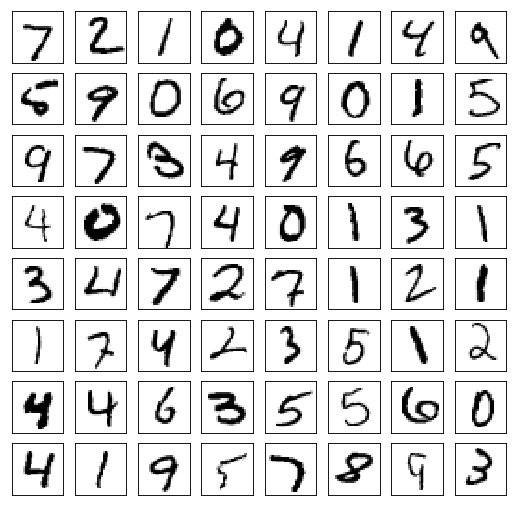

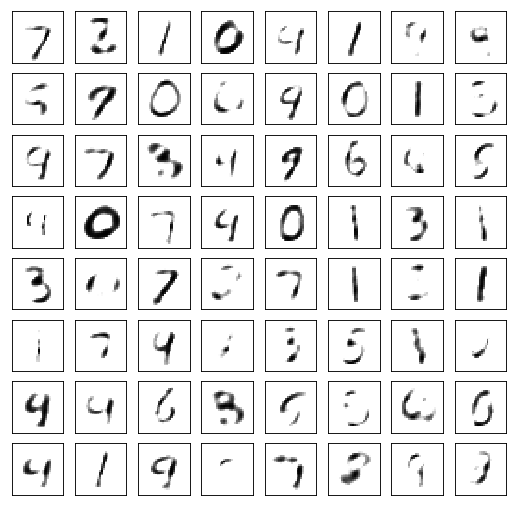

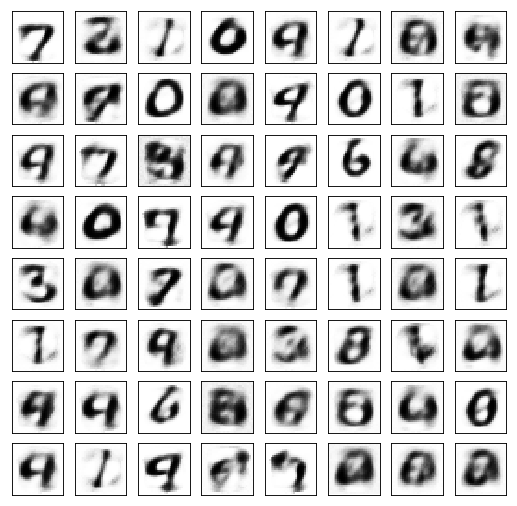

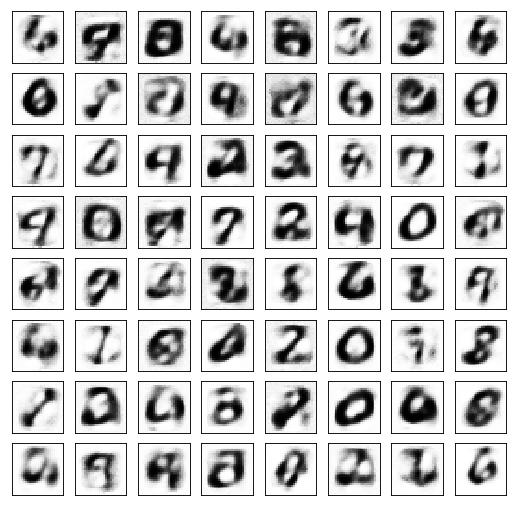

In [7]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [8]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(64)
    loss_stats = []
    
    gen_optim = optim.RMSprop([gen_img_par], lr=1e-4, weight_decay=0.)

    for i in range(1, 10000001):  
        
        target = model.E(gen_img_par.view(-1, 28*28))
        
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 2000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 5:    
                if ls > loss_stats[-2] and ls > loss_stats[-3]:
                    print ("Loss is rising .. stop")
                    break

        if i % 40000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

### Генерация изображений из батча

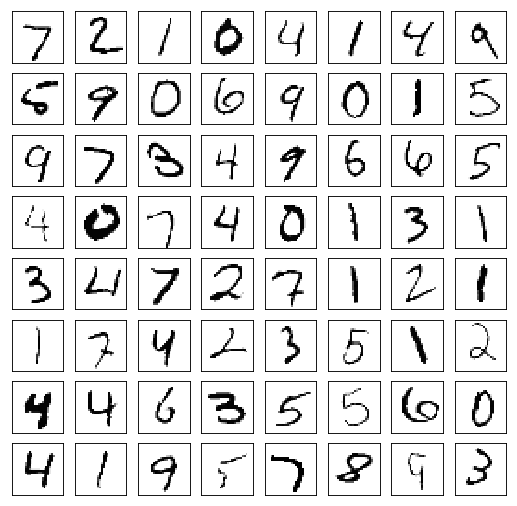

In [9]:
img, _ = next(iter(test_loader))
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.013540612533688545
Iteration 4000: loss=0.007873153313994408
Iteration 6000: loss=0.004098552744835615
Iteration 8000: loss=0.0025002569891512394
Iteration 10000: loss=0.001758148311637342
Iteration 12000: loss=0.0014164830790832639
Iteration 14000: loss=0.0012396137462928891
Iteration 16000: loss=0.0011277251178398728
Iteration 18000: loss=0.0010593115584924817
Iteration 20000: loss=0.0010151572059839964
Iteration 22000: loss=0.0009821790736168623
Iteration 24000: loss=0.0009576448937878013
Iteration 26000: loss=0.0009385476005263627
Iteration 28000: loss=0.000925213738810271
Iteration 30000: loss=0.0009149810066446662
Iteration 32000: loss=0.000905974127817899
Iteration 34000: loss=0.0008975723758339882
Iteration 36000: loss=0.0008913673809729517
Iteration 38000: loss=0.0008865796262398362
Iteration 40000: loss=0.0008821736555546522


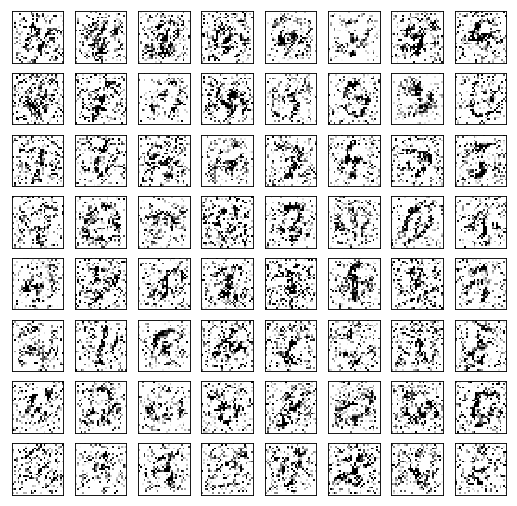

Iteration 42000: loss=0.0008786650141701102
Iteration 44000: loss=0.0008759964257478714
Iteration 46000: loss=0.0008738942560739815
Iteration 48000: loss=0.0008720576297491789
Iteration 50000: loss=0.000870445161126554
Iteration 52000: loss=0.0008689115638844669
Iteration 54000: loss=0.0008675186545588076
Iteration 56000: loss=0.0008663174230605364
Iteration 58000: loss=0.0008651325479149818
Iteration 60000: loss=0.0008639396983198822
Iteration 62000: loss=0.0008628350333310664
Iteration 64000: loss=0.0008609622018411756
Iteration 66000: loss=0.000859538558870554
Iteration 68000: loss=0.0008583939634263515
Iteration 70000: loss=0.0008571768994443119
Iteration 72000: loss=0.0008563901064917445
Iteration 74000: loss=0.0008557035471312702
Iteration 76000: loss=0.0008550171623937786
Iteration 78000: loss=0.0008539572008885443
Iteration 80000: loss=0.0008531158673577011


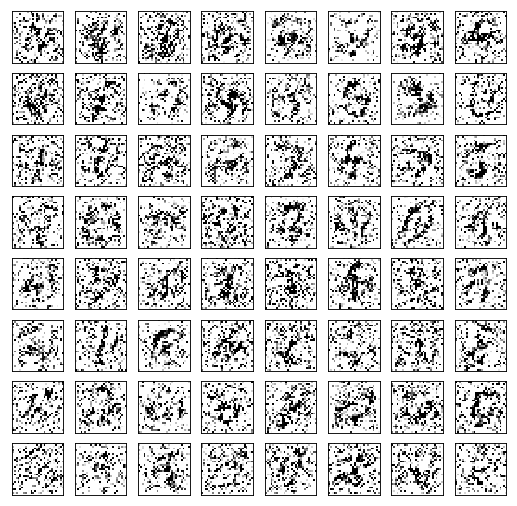

Iteration 82000: loss=0.0008526548044756055
Iteration 84000: loss=0.0008522379794158041
Iteration 86000: loss=0.0008515710942447186
Iteration 88000: loss=0.0008502083364874125
Iteration 90000: loss=0.0008492085617035627
Iteration 92000: loss=0.0008487446466460824
Iteration 94000: loss=0.0008484396385028958
Iteration 96000: loss=0.0008481648983433843
Iteration 98000: loss=0.0008478726376779377
Iteration 100000: loss=0.0008476125076413155
Iteration 102000: loss=0.000847365241497755
Iteration 104000: loss=0.0008471463806927204
Iteration 106000: loss=0.0008469303720630705
Iteration 108000: loss=0.0008465589489787817
Iteration 110000: loss=0.0008461565594188869
Iteration 112000: loss=0.0008459315286017954
Iteration 114000: loss=0.000845759641379118
Iteration 116000: loss=0.0008456000359728932
Iteration 118000: loss=0.0008454114431515336
Iteration 120000: loss=0.0008449867600575089


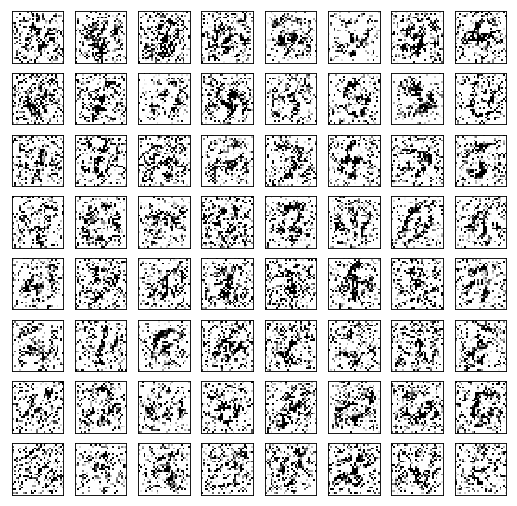

Iteration 122000: loss=0.0008441964746452868
Iteration 124000: loss=0.0008423886611126363
Iteration 126000: loss=0.0008419476798735559
Iteration 128000: loss=0.0008416790515184402
Iteration 130000: loss=0.0008414988988079131
Iteration 132000: loss=0.0008413598407059908
Iteration 134000: loss=0.0008412364986725152
Iteration 136000: loss=0.0008411131566390395
Iteration 138000: loss=0.000840988417621702
Iteration 140000: loss=0.0008408714784309268
Iteration 142000: loss=0.0008407599525526166
Iteration 144000: loss=0.0008406595443375409
Iteration 146000: loss=0.0008405747939832509
Iteration 148000: loss=0.000840500055346638
Iteration 150000: loss=0.0008404304971918464
Iteration 152000: loss=0.0008403639076277614
Iteration 154000: loss=0.0008402965613640845
Iteration 156000: loss=0.0008402291568927467
Iteration 158000: loss=0.0008401545928791165
Iteration 160000: loss=0.0008400589576922357


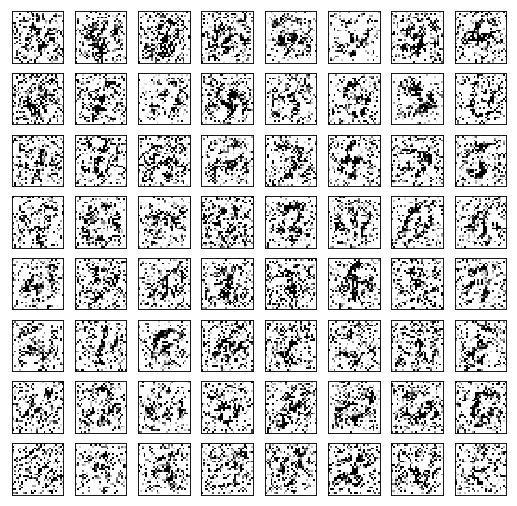

Iteration 162000: loss=0.0008399294456467032
Iteration 164000: loss=0.0008397575002163649
Iteration 166000: loss=0.0008396023185923696
Iteration 168000: loss=0.0008394781616516411
Iteration 170000: loss=0.0008393682655878365
Iteration 172000: loss=0.0008392767049372196
Iteration 174000: loss=0.0008392016170546412
Iteration 176000: loss=0.0008391408482566476
Iteration 178000: loss=0.0008390892762690783
Iteration 180000: loss=0.000839041022118181
Iteration 182000: loss=0.000838995969388634
Iteration 184000: loss=0.0008389544673264027
Iteration 186000: loss=0.0008389119175262749
Iteration 188000: loss=0.0008388706482946873
Iteration 190000: loss=0.0008388328715227544
Iteration 192000: loss=0.0008387917187064886
Iteration 194000: loss=0.0008387468988075852
Iteration 196000: loss=0.0008386702975258231
Iteration 198000: loss=0.0008384878747165203
Iteration 200000: loss=0.0008383563254028559


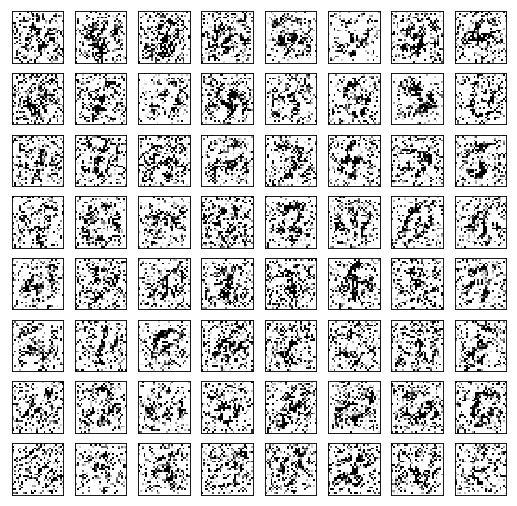

Iteration 202000: loss=0.0008382875821553171
Iteration 204000: loss=0.0008382403757423162
Iteration 206000: loss=0.0008382003870792687
Iteration 208000: loss=0.0008381619700230658
Iteration 210000: loss=0.0008381268125958741
Iteration 212000: loss=0.0008380940416827798
Iteration 214000: loss=0.0008380637154914439
Iteration 216000: loss=0.0008380339713767171
Iteration 218000: loss=0.0008380050421692431
Iteration 220000: loss=0.0008379775681532919
Iteration 222000: loss=0.0008379500359296799
Iteration 224000: loss=0.0008379206992685795
Iteration 226000: loss=0.0008378910133615136
Iteration 228000: loss=0.0008378570200875401
Iteration 230000: loss=0.0008378183702006936
Iteration 232000: loss=0.0008377800113521516
Iteration 234000: loss=0.0008377450867556036
Iteration 236000: loss=0.0008377156918868423
Iteration 238000: loss=0.000837690313346684
Iteration 240000: loss=0.000837666739244014


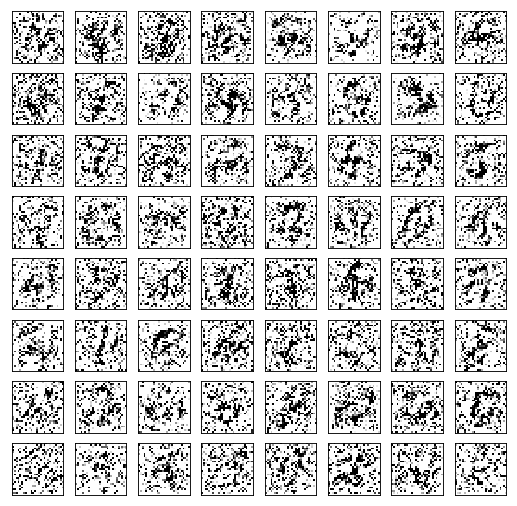

Iteration 242000: loss=0.0008376455516554415
Iteration 244000: loss=0.0008376252953894436
Iteration 246000: loss=0.000837605562992394
Iteration 248000: loss=0.0008375838515348732
Iteration 250000: loss=0.0008375636534765363
Iteration 252000: loss=0.0008375417091883719
Iteration 254000: loss=0.0008375142351724207
Iteration 256000: loss=0.0008374782046303153
Iteration 258000: loss=0.000837441417388618
Iteration 260000: loss=0.0008374099852517247
Iteration 262000: loss=0.0008373838500119746
Iteration 264000: loss=0.0008373601012863219
Iteration 266000: loss=0.0008373390301130712
Iteration 268000: loss=0.0008373192977160215
Iteration 270000: loss=0.0008373007876798511
Iteration 272000: loss=0.0008372822776436806
Iteration 274000: loss=0.0008372661541216075
Iteration 276000: loss=0.0008372506708838046
Iteration 278000: loss=0.0008372353622689843
Iteration 280000: loss=0.0008372205775231123


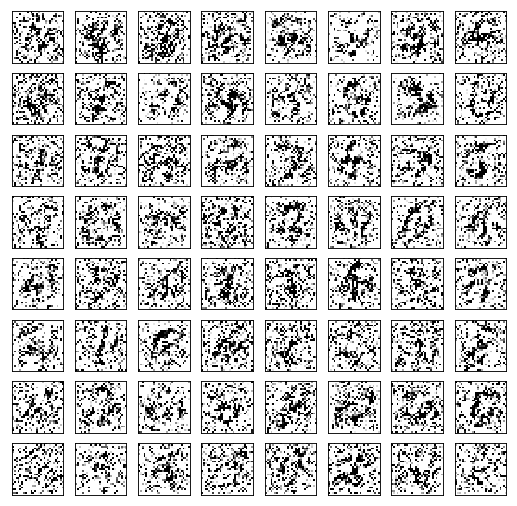

Iteration 282000: loss=0.0008372050360776484
Iteration 284000: loss=0.0008371894364245236
Iteration 286000: loss=0.000837170984596014
Iteration 288000: loss=0.0008371443254873157
Iteration 290000: loss=0.0008370634750463068
Iteration 292000: loss=0.000836642924696207
Iteration 294000: loss=0.0008364200475625694
Iteration 296000: loss=0.0008363292436115444
Iteration 298000: loss=0.0008362772641703486
Iteration 300000: loss=0.0008362432708963752
Iteration 302000: loss=0.0008362156222574413
Iteration 304000: loss=0.0008361883810721338
Iteration 306000: loss=0.00083614990580827
Iteration 308000: loss=0.0008360957726836205
Iteration 310000: loss=0.0008360237698070705
Iteration 312000: loss=0.0008359552593901753
Iteration 314000: loss=0.0008359195198863745
Iteration 316000: loss=0.0008358904160559177
Iteration 318000: loss=0.0008358628256246448
Iteration 320000: loss=0.0008358410559594631


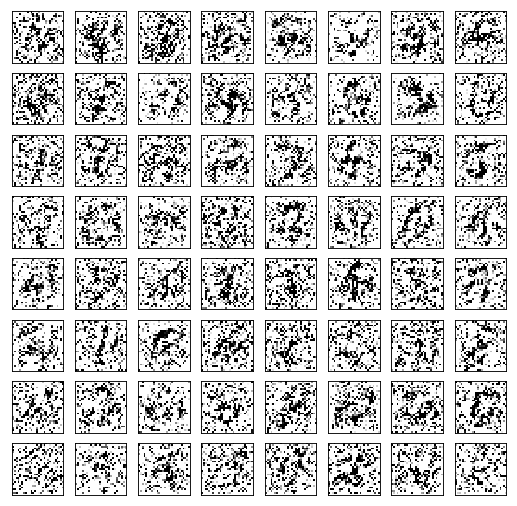

Iteration 322000: loss=0.0008358255727216601
Iteration 324000: loss=0.00083581154467538
Iteration 326000: loss=0.0008358003688044846
Iteration 328000: loss=0.0008357875631190836
Iteration 330000: loss=0.0008357775514014065
Iteration 332000: loss=0.0008357660262845457
Iteration 334000: loss=0.000835753045976162
Iteration 336000: loss=0.0008357412298209965
Iteration 338000: loss=0.0008357280748896301
Iteration 340000: loss=0.0008357117767445743
Iteration 342000: loss=0.0008356901817023754
Iteration 344000: loss=0.0008356629405170679
Iteration 346000: loss=0.0008356301113963127
Iteration 348000: loss=0.00083559425547719
Iteration 350000: loss=0.0008355598547495902
Iteration 352000: loss=0.0008355346508324146
Iteration 354000: loss=0.0008355150348506868
Iteration 356000: loss=0.0008355002501048148
Iteration 358000: loss=0.0008354864548891783
Iteration 360000: loss=0.0008354739984497428


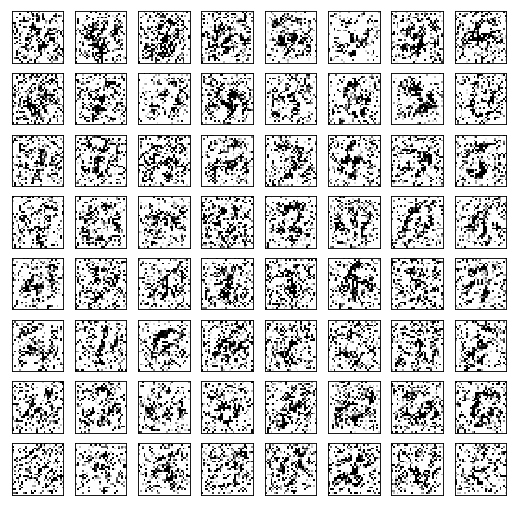

Iteration 362000: loss=0.0008354623569175601
Iteration 364000: loss=0.0008354492019861937
Iteration 366000: loss=0.0008354372694157064
Iteration 368000: loss=0.0008354256278835237
Iteration 370000: loss=0.0008354127639904618
Iteration 372000: loss=0.0008353960001841187
Iteration 374000: loss=0.000835367594845593
Iteration 376000: loss=0.0008353018783964217
Iteration 378000: loss=0.0008352331351488829
Iteration 380000: loss=0.0008352071163244545
Iteration 382000: loss=0.0008351880242116749
Iteration 384000: loss=0.0008351701544597745
Iteration 386000: loss=0.0008351487340405583
Iteration 388000: loss=0.0008351209107786417
Iteration 390000: loss=0.0008350771386176348
Iteration 392000: loss=0.0008350301068276167
Iteration 394000: loss=0.0008350010612048209
Iteration 396000: loss=0.0008349806885235012
Iteration 398000: loss=0.0008349653799086809
Iteration 400000: loss=0.0008349506533704698


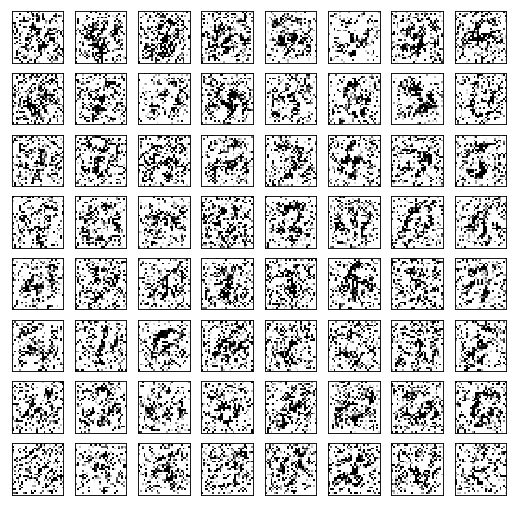

Iteration 402000: loss=0.0008349366253241897
Iteration 404000: loss=0.0008349223644472659
Iteration 406000: loss=0.0008349060663022101
Iteration 408000: loss=0.0008348885457962751
Iteration 410000: loss=0.000834871141705662
Iteration 412000: loss=0.0008348567062057555
Iteration 414000: loss=0.0008348440169356763
Iteration 416000: loss=0.0008348319097422063
Iteration 418000: loss=0.0008348203264176846
Iteration 420000: loss=0.0008348064147867262
Iteration 422000: loss=0.0008347876137122512
Iteration 424000: loss=0.000834756123367697
Iteration 426000: loss=0.0008346925023943186
Iteration 428000: loss=0.000834620906971395
Iteration 430000: loss=0.0008345734095200896
Iteration 432000: loss=0.0008345419773831964
Iteration 434000: loss=0.0008345211390405893
Iteration 436000: loss=0.000834507227409631
Iteration 438000: loss=0.0008344960515387356
Iteration 440000: loss=0.0008344869129359722


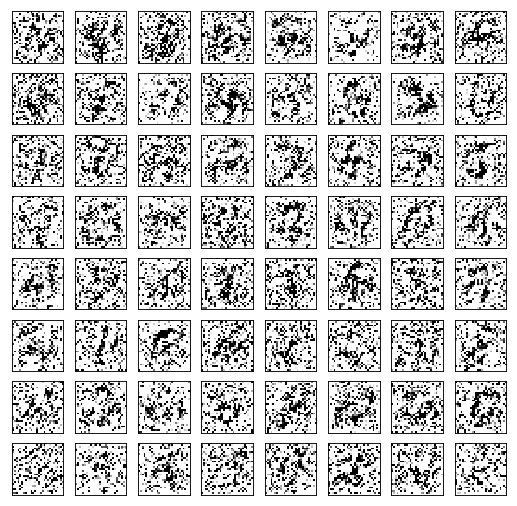

Iteration 442000: loss=0.0008344794623553753
Iteration 444000: loss=0.0008344726520590484
Iteration 446000: loss=0.0008344658417627215
Iteration 448000: loss=0.000834458798635751
Iteration 450000: loss=0.000834453443530947
Iteration 452000: loss=0.0008344467496499419
Iteration 454000: loss=0.0008344412199221551
Iteration 456000: loss=0.0008344369125552475
Iteration 458000: loss=0.0008344309753738344
Iteration 460000: loss=0.0008344253874383867
Iteration 462000: loss=0.0008344200323335826
Iteration 464000: loss=0.0008344154339283705
Iteration 466000: loss=0.0008344095549546182
Iteration 468000: loss=0.000834404316265136
Iteration 470000: loss=0.0008343993104062974
Iteration 472000: loss=0.0008343926165252924
Iteration 474000: loss=0.0008343879017047584
Iteration 476000: loss=0.0008343806257471442
Iteration 478000: loss=0.0008343736990354955
Iteration 480000: loss=0.0008343645022250712


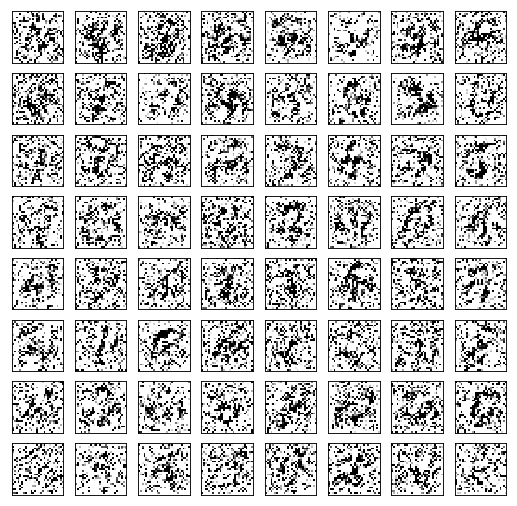

Iteration 482000: loss=0.0008343527442775667
Iteration 484000: loss=0.000834326317999512
Iteration 486000: loss=0.0008342412766069174
Iteration 488000: loss=0.0008340790518559515
Iteration 490000: loss=0.0008339566411450505
Iteration 492000: loss=0.0008338237530551851
Iteration 494000: loss=0.000833761936519295
Iteration 496000: loss=0.0008337335311807692
Iteration 498000: loss=0.0008337138569913805
Iteration 500000: loss=0.0008336983155459166
Iteration 502000: loss=0.000833684578537941
Iteration 504000: loss=0.0008336714818142354
Iteration 506000: loss=0.0008336592582054436
Iteration 508000: loss=0.0008336479659192264
Iteration 510000: loss=0.0008336370228789747
Iteration 512000: loss=0.0008336239843629301
Iteration 514000: loss=0.0008336061146110296
Iteration 516000: loss=0.0008335845195688307
Iteration 518000: loss=0.0008335691527463496
Iteration 520000: loss=0.0008335597231052816


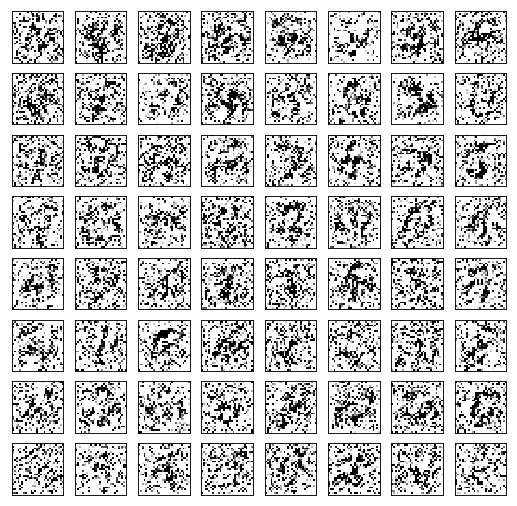

Iteration 522000: loss=0.0008335526217706501
Iteration 524000: loss=0.0008335468010045588
Iteration 526000: loss=0.0008335401071235538
Iteration 528000: loss=0.000833533238619566
Iteration 530000: loss=0.0008335252059623599
Iteration 532000: loss=0.0008335143211297691
Iteration 534000: loss=0.0008334959275089204
Iteration 536000: loss=0.0008334642043337226
Iteration 538000: loss=0.0008334276499226689
Iteration 540000: loss=0.0008334045414812863
Iteration 542000: loss=0.0008333911537192762
Iteration 544000: loss=0.0008333804435096681
Iteration 546000: loss=0.000833369791507721
Iteration 548000: loss=0.0008333612931892276
Iteration 550000: loss=0.0008333541918545961
Iteration 552000: loss=0.0008333483128808439
Iteration 554000: loss=0.0008333428995683789
Iteration 556000: loss=0.0008333378355018795
Iteration 558000: loss=0.0008333324803970754
Iteration 560000: loss=0.0008333277073688805


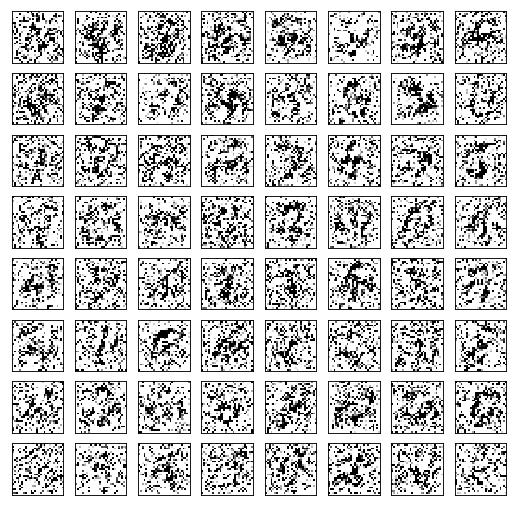

Iteration 562000: loss=0.0008333232835866511
Iteration 564000: loss=0.0008333186851814389
Iteration 566000: loss=0.0008333135046996176
Iteration 568000: loss=0.0008333084406331182
Iteration 570000: loss=0.0008333030273206532
Iteration 572000: loss=0.0008332980796694756
Iteration 574000: loss=0.0008332913275808096
Iteration 576000: loss=0.0008332844590768218
Iteration 578000: loss=0.0008332752622663975
Iteration 580000: loss=0.0008332602446898818
Iteration 582000: loss=0.0008332328870892525
Iteration 584000: loss=0.000833197555039078
Iteration 586000: loss=0.0008331735152751207
Iteration 588000: loss=0.0008331590215675533
Iteration 590000: loss=0.0008331454009748995
Iteration 592000: loss=0.0008331320714205503
Iteration 594000: loss=0.0008331098943017423
Iteration 596000: loss=0.0008330243872478604
Iteration 598000: loss=0.0008325400413013995
Iteration 600000: loss=0.0008322314824908972


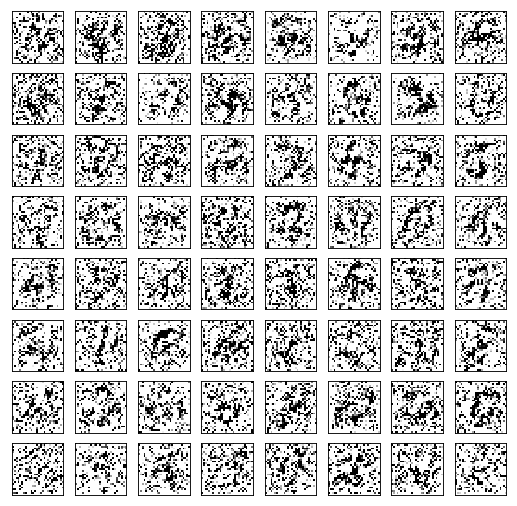

Iteration 602000: loss=0.0008321386994794011
Iteration 604000: loss=0.0008320675115101039
Iteration 606000: loss=0.0008319194312207401
Iteration 608000: loss=0.0008317982428707182
Iteration 610000: loss=0.0008317314786836505
Iteration 612000: loss=0.000831696845125407
Iteration 614000: loss=0.0008316775783896446
Iteration 616000: loss=0.0008316641324199736
Iteration 618000: loss=0.0008316530147567391
Iteration 620000: loss=0.0008316417224705219
Iteration 622000: loss=0.0008316293242387474
Iteration 624000: loss=0.0008316119783557951
Iteration 626000: loss=0.0008315821178257465
Iteration 628000: loss=0.0008315307204611599
Iteration 630000: loss=0.000831490964628756
Iteration 632000: loss=0.0008314672159031034
Iteration 634000: loss=0.0008314511505886912
Iteration 636000: loss=0.0008314386359415948
Iteration 638000: loss=0.0008314286824315786
Iteration 640000: loss=0.000831419660244137


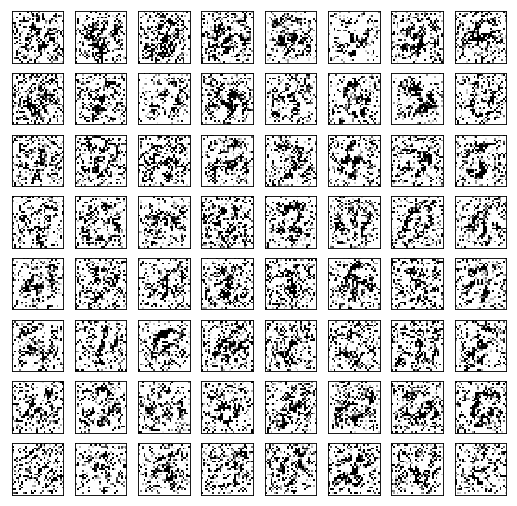

Iteration 642000: loss=0.0008314130827784538
Iteration 644000: loss=0.0008314065635204315
Iteration 646000: loss=0.0008314003353007138
Iteration 648000: loss=0.0008313945727422833
Iteration 650000: loss=0.0008313895086757839
Iteration 652000: loss=0.0008313842117786407
Iteration 654000: loss=0.0008313796715810895
Iteration 656000: loss=0.0008313745493069291
Iteration 658000: loss=0.0008313700091093779
Iteration 660000: loss=0.0008313642465509474
Iteration 662000: loss=0.000831359124276787
Iteration 664000: loss=0.0008313536527566612
Iteration 666000: loss=0.0008313492289744318
Iteration 668000: loss=0.0008313434664160013
Iteration 670000: loss=0.0008313370635733008
Iteration 672000: loss=0.0008313284488394856
Iteration 674000: loss=0.0008313157013617456
Iteration 676000: loss=0.0008312771678902209
Iteration 678000: loss=0.0008311324054375291
Iteration 680000: loss=0.0008310138946399093


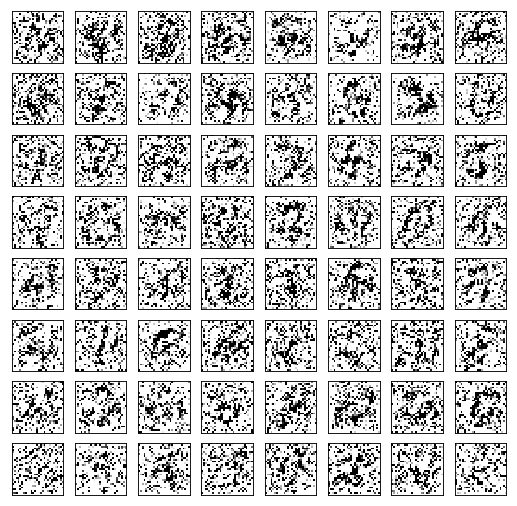

Iteration 682000: loss=0.0008309787372127175
Iteration 684000: loss=0.0008309634285978973
Iteration 686000: loss=0.0008309541153721511
Iteration 688000: loss=0.0008309467229992151
Iteration 690000: loss=0.0008309399709105492
Iteration 692000: loss=0.0008309341501444578
Iteration 694000: loss=0.0008309297845698893
Iteration 696000: loss=0.0008309255936183035
Iteration 698000: loss=0.0008309197728522122
Iteration 700000: loss=0.0008309147669933736
Iteration 702000: loss=0.0008309109252877533
Iteration 704000: loss=0.0008309056865982711
Iteration 706000: loss=0.0008309013792313635
Iteration 708000: loss=0.0008308968390338123
Iteration 710000: loss=0.0008308908436447382
Iteration 712000: loss=0.0008308856631629169
Iteration 714000: loss=0.0008308813557960093
Iteration 716000: loss=0.0008308762335218489
Iteration 718000: loss=0.0008308718679472804
Iteration 720000: loss=0.0008308676187880337


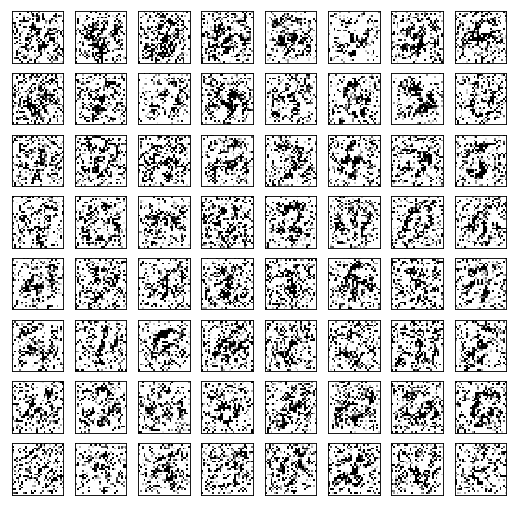

Iteration 722000: loss=0.0008308631367981434
Iteration 724000: loss=0.0008308588876388967
Iteration 726000: loss=0.0008308541728183627
Iteration 728000: loss=0.0008308505639433861
Iteration 730000: loss=0.0008308454416692257
Iteration 732000: loss=0.0008308411343023181
Iteration 734000: loss=0.0008308359538204968
Iteration 736000: loss=0.00083082978380844
Iteration 738000: loss=0.0008308229153044522
Iteration 740000: loss=0.0008308143587782979
Iteration 742000: loss=0.0008308059768751264
Iteration 744000: loss=0.000830798177048564
Iteration 746000: loss=0.0008307920070365071
Iteration 748000: loss=0.0008307854877784848
Iteration 750000: loss=0.0008307808311656117
Iteration 752000: loss=0.0008307757670991123
Iteration 754000: loss=0.0008307706448249519
Iteration 756000: loss=0.0008307661046274006
Iteration 758000: loss=0.0008307617390528321
Iteration 760000: loss=0.0008307573734782636


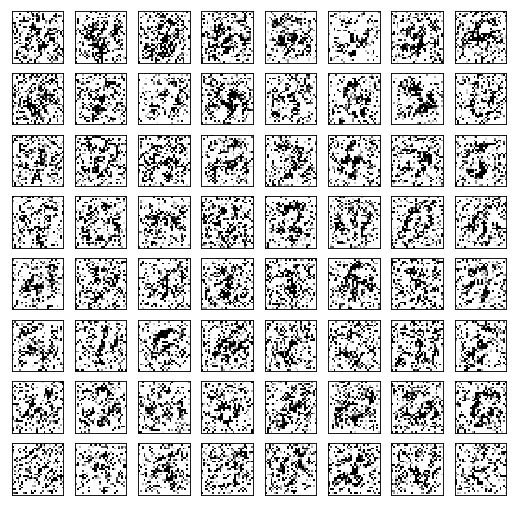

Iteration 762000: loss=0.0008307530079036951
Iteration 764000: loss=0.0008307489915750921
Iteration 766000: loss=0.0008307453244924545
Iteration 768000: loss=0.0008307411335408688
Iteration 770000: loss=0.0008307383977808058
Iteration 772000: loss=0.0008307345560751855
Iteration 774000: loss=0.0008307326352223754
Iteration 776000: loss=0.0008307296084240079
Iteration 778000: loss=0.0008307273383252323
Iteration 780000: loss=0.0008307246607728302
Iteration 782000: loss=0.0008307214011438191
Iteration 784000: loss=0.000830718083307147
Iteration 786000: loss=0.0008307146490551531
Iteration 788000: loss=0.0008307111565954983
Iteration 790000: loss=0.0008307069074362516
Iteration 792000: loss=0.0008307027746923268
Iteration 794000: loss=0.0008306984091177583
Iteration 796000: loss=0.0008306947420351207
Iteration 798000: loss=0.0008306904346682131
Iteration 800000: loss=0.0008306865929625928


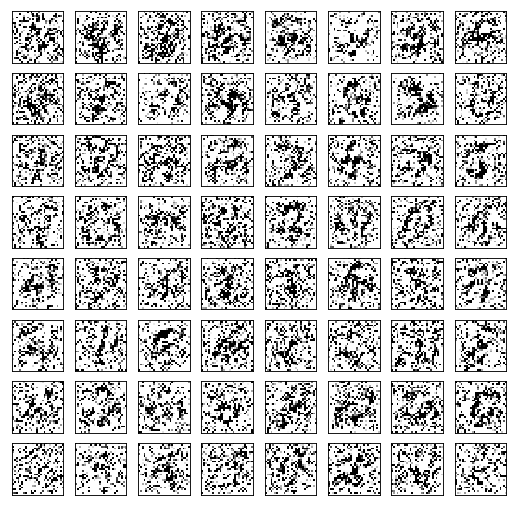

Iteration 802000: loss=0.0008306832751259208
Iteration 804000: loss=0.0008306812960654497
Iteration 806000: loss=0.0008306786185130477
Iteration 808000: loss=0.0008306765230372548
Iteration 810000: loss=0.000830674369353801
Iteration 812000: loss=0.0008306726813316345
Iteration 814000: loss=0.0008306712843477726
Iteration 816000: loss=0.0008306687232106924
Iteration 818000: loss=0.0008306675590574741
Iteration 820000: loss=0.000830664939712733
Iteration 822000: loss=0.0008306634263135493
Iteration 824000: loss=0.0008306617382913828
Iteration 826000: loss=0.0008306603995151818
Iteration 828000: loss=0.000830658245831728
Iteration 830000: loss=0.0008306563831865788
Iteration 832000: loss=0.0008306546369567513
Iteration 834000: loss=0.0008306524832732975
Iteration 836000: loss=0.000830650853458792
Iteration 838000: loss=0.0008306485833600163
Iteration 840000: loss=0.0008306469535455108


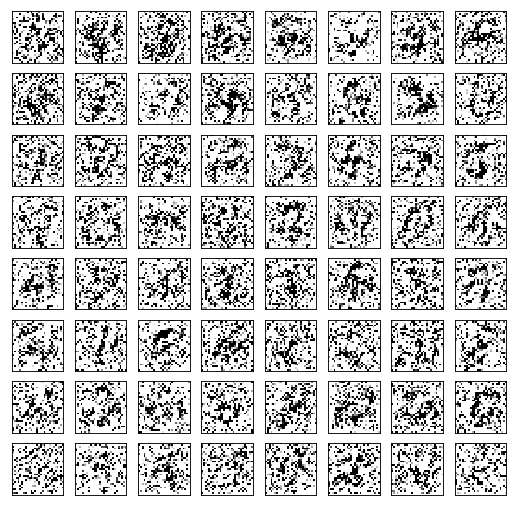

Iteration 842000: loss=0.0008306445088237524
Iteration 844000: loss=0.0008306409581564367
Iteration 846000: loss=0.0008306358940899372
Iteration 848000: loss=0.0008306276868097484
Iteration 850000: loss=0.000830602366477251
Iteration 852000: loss=0.0008304881630465388
Iteration 854000: loss=0.0008303287904709578
Iteration 856000: loss=0.0008302410715259612
Iteration 858000: loss=0.00083019002340734
Iteration 860000: loss=0.0008301585912704468
Iteration 862000: loss=0.0008301371708512306
Iteration 864000: loss=0.0008301110356114805
Iteration 866000: loss=0.0008300626650452614
Iteration 868000: loss=0.0008300201734527946
Iteration 870000: loss=0.0008299969485960901
Iteration 872000: loss=0.0008299809996969998
Iteration 874000: loss=0.0008299705223180354
Iteration 876000: loss=0.0008299625478684902
Iteration 878000: loss=0.0008299561450257897
Iteration 880000: loss=0.0008299504406750202


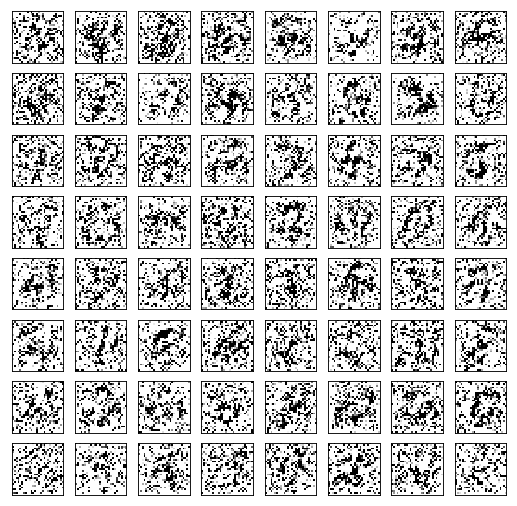

Iteration 882000: loss=0.0008299457258544862
Iteration 884000: loss=0.000829941825941205
Iteration 886000: loss=0.000829938508104533
Iteration 888000: loss=0.0008299348992295563
Iteration 890000: loss=0.0008299320470541716
Iteration 892000: loss=0.000829928379971534
Iteration 894000: loss=0.0008299254113808274
Iteration 896000: loss=0.0008299227338284254
Iteration 898000: loss=0.0008299206965602934
Iteration 900000: loss=0.0008299176697619259
Iteration 902000: loss=0.0008299150504171848
Iteration 904000: loss=0.0008299131877720356
Iteration 906000: loss=0.0008299108594655991
Iteration 908000: loss=0.0008299084147438407
Iteration 910000: loss=0.0008299066685140133
Iteration 912000: loss=0.0008299049804918468
Iteration 914000: loss=0.0008299031178466976
Iteration 916000: loss=0.0008299016626551747
Iteration 918000: loss=0.0008298996253870428
Iteration 920000: loss=0.0008298977627418935


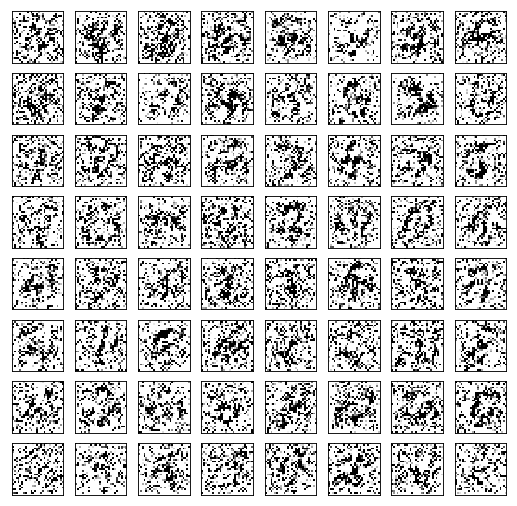

Iteration 922000: loss=0.0008298960165120661
Iteration 924000: loss=0.0008298940374515951
Iteration 926000: loss=0.0008298925240524113
Iteration 928000: loss=0.0008298916509374976
Iteration 930000: loss=0.0008298906614072621
Iteration 932000: loss=0.0008298893226310611
Iteration 934000: loss=0.0008298877510242164
Iteration 936000: loss=0.0008298863540403545
Iteration 938000: loss=0.0008298847242258489
Iteration 940000: loss=0.0008298832690343261
Iteration 942000: loss=0.0008298819302581251
Iteration 944000: loss=0.0008298802422359586
Iteration 946000: loss=0.0008298791944980621
Iteration 948000: loss=0.0008298778557218611
Iteration 950000: loss=0.0008298765169456601
Iteration 952000: loss=0.0008298747125081718
Iteration 954000: loss=0.0008298740140162408
Iteration 956000: loss=0.0008298728498630226
Iteration 958000: loss=0.000829871918540448
Iteration 960000: loss=0.0008298709290102124


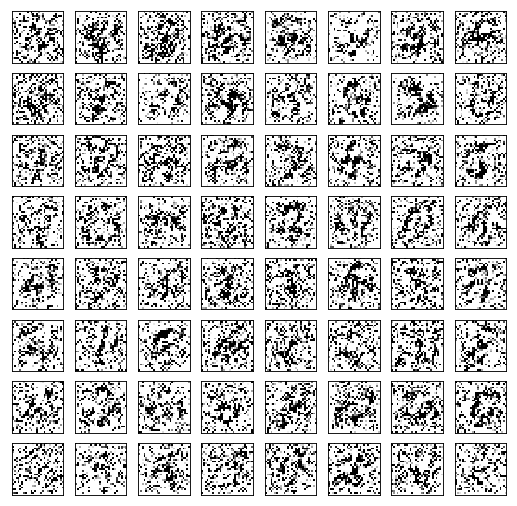

Iteration 962000: loss=0.0008298695320263505
Iteration 964000: loss=0.0008298683096654713
Iteration 966000: loss=0.0008298669708892703
Iteration 968000: loss=0.0008298651082441211
Iteration 970000: loss=0.0008298638858832419
Iteration 972000: loss=0.0008298624306917191
Iteration 974000: loss=0.0008298612665385008
Iteration 976000: loss=0.0008298596367239952
Iteration 978000: loss=0.0008298586471937597
Iteration 980000: loss=0.000829857774078846
Iteration 982000: loss=0.0008298565517179668
Iteration 984000: loss=0.0008298548054881394
Iteration 986000: loss=0.0008298536413349211
Iteration 988000: loss=0.0008298523025587201
Iteration 990000: loss=0.0008298509637825191
Iteration 992000: loss=0.0008298495667986572
Iteration 994000: loss=0.000829848984722048
Iteration 996000: loss=0.0008298472384922206
Iteration 998000: loss=0.0008298451430164278
Iteration 1000000: loss=0.0008298435714095831


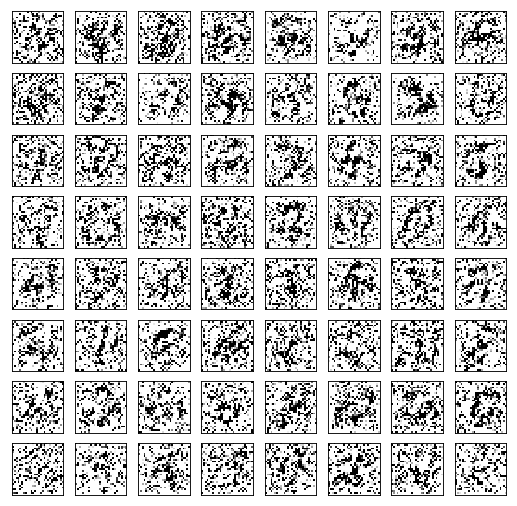

Iteration 1002000: loss=0.0008298420580103993
Iteration 1004000: loss=0.0008298401953652501
Iteration 1006000: loss=0.0008298385655507445
Iteration 1008000: loss=0.0008298367611132562
Iteration 1010000: loss=0.0008298352477140725
Iteration 1012000: loss=0.0008298340253531933
Iteration 1014000: loss=0.0008298330358229578
Iteration 1016000: loss=0.0008298311149701476
Iteration 1018000: loss=0.0008298303000628948
Iteration 1020000: loss=0.0008298290777020156
Iteration 1022000: loss=0.0008298282627947628
Iteration 1024000: loss=0.0008298272150568664
Iteration 1026000: loss=0.000829826109111309
Iteration 1028000: loss=0.0008298252359963953
Iteration 1030000: loss=0.0008298243628814816
Iteration 1032000: loss=0.0008298239554278553
Iteration 1034000: loss=0.0008298230823129416
Iteration 1036000: loss=0.0008298219763673842
Iteration 1038000: loss=0.0008298211614601314
Iteration 1040000: loss=0.0008298203465528786


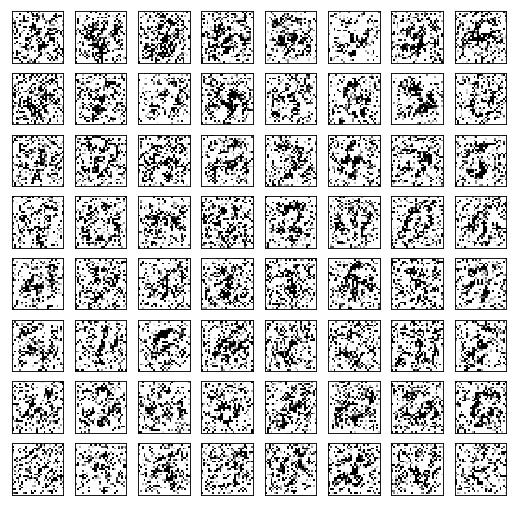

Iteration 1042000: loss=0.0008298192988149822
Iteration 1044000: loss=0.0008298179600387812
Iteration 1046000: loss=0.0008298174943774939
Iteration 1048000: loss=0.0008298165048472583
Iteration 1050000: loss=0.0008298156317323446
Iteration 1052000: loss=0.0008298145839944482
Iteration 1054000: loss=0.0008298141765408218
Iteration 1056000: loss=0.0008298131870105863
Iteration 1058000: loss=0.0008298125467263162
Iteration 1060000: loss=0.0008298113825730979
Iteration 1062000: loss=0.0008298105676658452
Iteration 1064000: loss=0.0008298096363432705
Iteration 1066000: loss=0.0008298090542666614
Iteration 1068000: loss=0.0008298082393594086
Iteration 1070000: loss=0.0008298074826598167
Iteration 1072000: loss=0.000829806609544903
Iteration 1074000: loss=0.0008298056200146675
Iteration 1076000: loss=0.000829805270768702
Iteration 1078000: loss=0.0008298039902001619
Iteration 1080000: loss=0.0008298030006699264


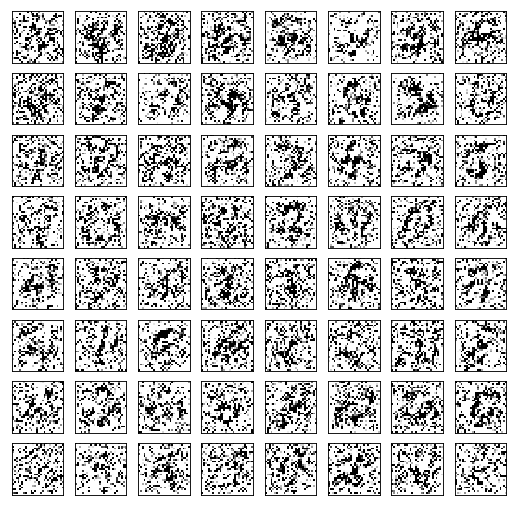

Iteration 1082000: loss=0.0008298014872707427
Iteration 1084000: loss=0.0008298009051941335
Iteration 1086000: loss=0.0008298003231175244
Iteration 1088000: loss=0.0008297996246255934
Iteration 1090000: loss=0.0008297986933030188
Iteration 1092000: loss=0.000829797878395766
Iteration 1094000: loss=0.0008297967724502087
Iteration 1096000: loss=0.0008297961321659386
Iteration 1098000: loss=0.0008297955500893295
Iteration 1100000: loss=0.0008297944441437721
Iteration 1102000: loss=0.0008297930471599102
Iteration 1104000: loss=0.0008297922904603183
Iteration 1106000: loss=0.0008297915337607265
Iteration 1108000: loss=0.0008297900203615427
Iteration 1110000: loss=0.0008297888562083244
Iteration 1112000: loss=0.0008297885651700199
Iteration 1114000: loss=0.0008297876338474452
Iteration 1116000: loss=0.000829786469694227
Iteration 1118000: loss=0.0008297854219563305
Iteration 1120000: loss=0.0008297849562950432


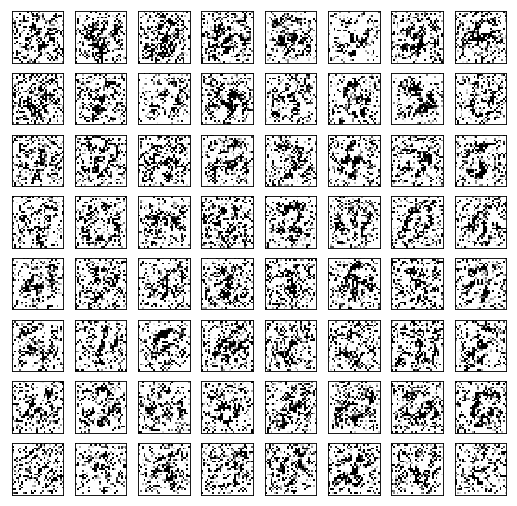

Iteration 1122000: loss=0.0008297834428958595
Iteration 1124000: loss=0.0008297820459119976
Iteration 1126000: loss=0.0008297814638353884
Iteration 1128000: loss=0.0008297802414745092
Iteration 1130000: loss=0.0008297782042063773
Iteration 1132000: loss=0.0008297762251459062
Iteration 1134000: loss=0.0008297740714624524
Iteration 1136000: loss=0.0008297714521177113
Iteration 1138000: loss=0.0008297674357891083
Iteration 1140000: loss=0.0008297605672851205
Iteration 1142000: loss=0.0008297471213154495
Iteration 1144000: loss=0.0008297119056805968
Iteration 1146000: loss=0.0008296503801830113
Iteration 1148000: loss=0.0008296080050058663
Iteration 1150000: loss=0.0008295881561934948
Iteration 1152000: loss=0.0008295782608911395
Iteration 1154000: loss=0.0008295730804093182
Iteration 1156000: loss=0.0008295697625726461
Iteration 1158000: loss=0.0008295673760585487
Iteration 1160000: loss=0.0008295655716210604


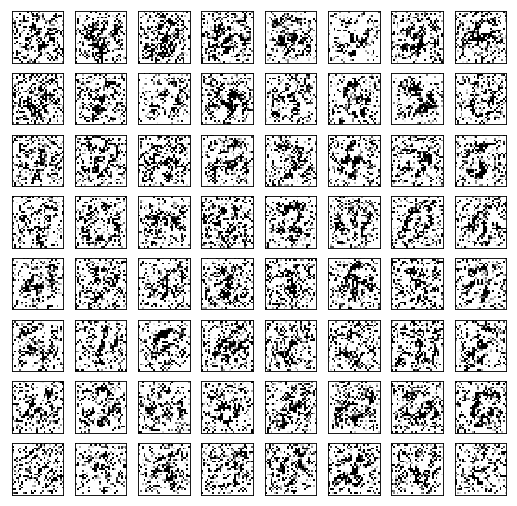

Iteration 1162000: loss=0.0008295631851069629
Iteration 1164000: loss=0.000829561788123101
Iteration 1166000: loss=0.0008295606239698827
Iteration 1168000: loss=0.0008295596344396472
Iteration 1170000: loss=0.0008295588777400553
Iteration 1172000: loss=0.0008295578300021589
Iteration 1174000: loss=0.0008295566658489406
Iteration 1176000: loss=0.0008295555599033833
Iteration 1178000: loss=0.0008295545121654868
Iteration 1180000: loss=0.0008295538718812168
Iteration 1182000: loss=0.0008295532315969467
Iteration 1184000: loss=0.0008295524166896939
Iteration 1186000: loss=0.0008295511943288147
Iteration 1188000: loss=0.000829550379421562
Iteration 1190000: loss=0.000829550321213901
Iteration 1192000: loss=0.0008295495645143092
Iteration 1194000: loss=0.0008295486913993955
Iteration 1196000: loss=0.0008295474108308554
Iteration 1198000: loss=0.0008295461302623153
Iteration 1200000: loss=0.0008295453153550625


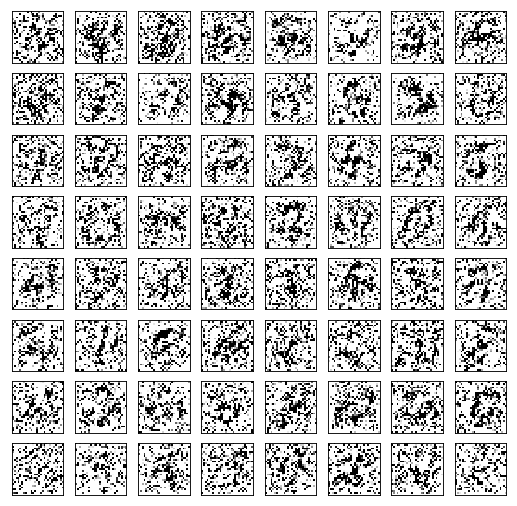

Iteration 1202000: loss=0.0008295444422401488
Iteration 1204000: loss=0.0008295434527099133
Iteration 1206000: loss=0.0008295427542179823
Iteration 1208000: loss=0.0008295418228954077
Iteration 1210000: loss=0.0008295406587421894
Iteration 1212000: loss=0.0008295393199659884
Iteration 1214000: loss=0.0008295380393974483
Iteration 1216000: loss=0.0008295367006212473
Iteration 1218000: loss=0.0008295358857139945
Iteration 1220000: loss=0.000829534896183759
Iteration 1222000: loss=0.0008295336156152189
Iteration 1224000: loss=0.0008295329171232879
Iteration 1226000: loss=0.0008295313455164433
Iteration 1228000: loss=0.0008295300067402422
Iteration 1230000: loss=0.0008295291336253285
Iteration 1232000: loss=0.0008295283769257367
Iteration 1234000: loss=0.000829527503810823
Iteration 1236000: loss=0.0008295266306959093
Iteration 1238000: loss=0.0008295257575809956
Iteration 1240000: loss=0.0008295248844660819


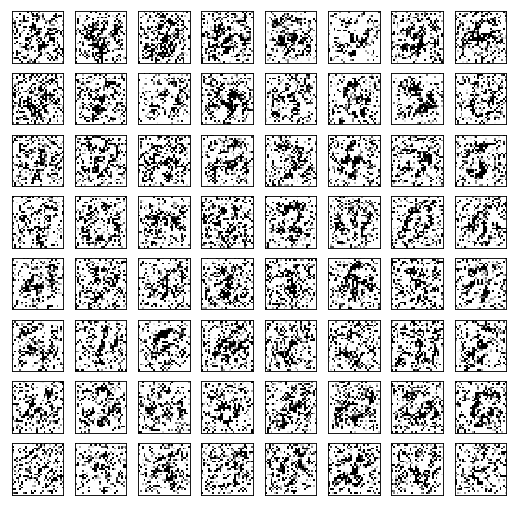

Iteration 1242000: loss=0.0008295238949358463
Iteration 1244000: loss=0.0008295229054056108
Iteration 1246000: loss=0.0008295219158753753
Iteration 1248000: loss=0.0008295213337987661
Iteration 1250000: loss=0.0008295204606838524
Iteration 1252000: loss=0.0008295195875689387
Iteration 1254000: loss=0.0008295188890770078
Iteration 1256000: loss=0.0008295178413391113
Iteration 1258000: loss=0.000829517375677824
Iteration 1260000: loss=0.0008295169100165367
Iteration 1262000: loss=0.0008295156294479966
Iteration 1264000: loss=0.000829514057841152
Iteration 1266000: loss=0.0008295131265185773
Iteration 1268000: loss=0.00082951266085729
Iteration 1270000: loss=0.0008295119041576982
Iteration 1272000: loss=0.0008295108564198017
Iteration 1274000: loss=0.0008295096922665834
Iteration 1276000: loss=0.0008295089937746525
Iteration 1278000: loss=0.0008295085863210261
Iteration 1280000: loss=0.0008295077714137733


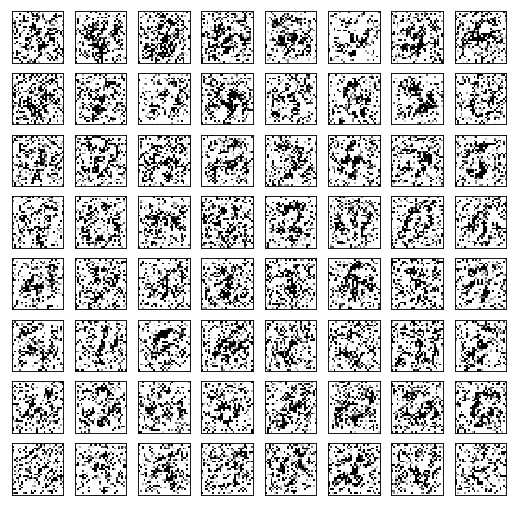

Iteration 1282000: loss=0.0008295071893371642
Iteration 1284000: loss=0.0008295063162222505
Iteration 1286000: loss=0.0008295061415992677
Iteration 1288000: loss=0.0008295049774460495
Iteration 1290000: loss=0.0008295042789541185
Iteration 1292000: loss=0.000829503929708153
Iteration 1294000: loss=0.000829503231216222
Iteration 1296000: loss=0.0008295028237625957
Iteration 1298000: loss=0.0008295021834783256
Iteration 1300000: loss=0.0008295011939480901
Iteration 1302000: loss=0.0008295004954561591
Iteration 1304000: loss=0.000829499214887619
Iteration 1306000: loss=0.0008294989820569754
Iteration 1308000: loss=0.0008294989820569754
Iteration 1310000: loss=0.000829498574603349
Iteration 1312000: loss=0.0008294982253573835
Iteration 1314000: loss=0.0008294979343190789
Iteration 1316000: loss=0.000829497876111418
Iteration 1318000: loss=0.0008294973522424698
Iteration 1320000: loss=0.000829497177619487


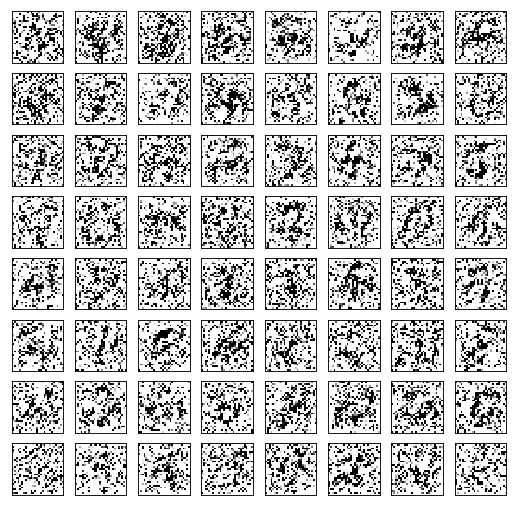

Iteration 1322000: loss=0.0008294966537505388
Iteration 1324000: loss=0.0008294956060126424
Iteration 1326000: loss=0.0008294950821436942
Iteration 1328000: loss=0.0008294946164824069
Iteration 1330000: loss=0.0008294939179904759
Iteration 1332000: loss=0.0008294935105368495
Iteration 1334000: loss=0.0008294933359138668
Iteration 1336000: loss=0.0008294926956295967
Iteration 1338000: loss=0.0008294921135529876
Iteration 1340000: loss=0.0008294916478917003
Iteration 1342000: loss=0.0008294912404380739
Iteration 1344000: loss=0.0008294910076074302
Iteration 1346000: loss=0.0008294906583614647
Iteration 1348000: loss=0.0008294900180771947
Iteration 1350000: loss=0.0008294893777929246
Iteration 1352000: loss=0.0008294893195852637
Iteration 1354000: loss=0.0008294886210933328
Iteration 1356000: loss=0.0008294882718473673
Iteration 1358000: loss=0.0008294878643937409
Iteration 1360000: loss=0.0008294872823171318


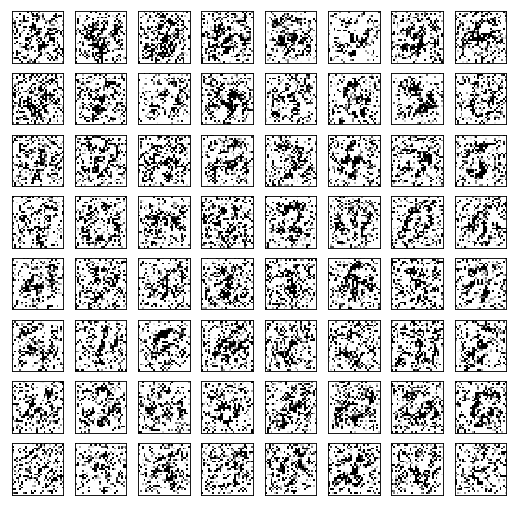

Iteration 1362000: loss=0.0008294868748635054
Iteration 1364000: loss=0.0008294866420328617
Iteration 1366000: loss=0.0008294858853332698
Iteration 1368000: loss=0.0008294853614643216
Iteration 1370000: loss=0.0008294849540106952
Iteration 1372000: loss=0.0008294847211800516
Iteration 1374000: loss=0.0008294845465570688
Iteration 1376000: loss=0.0008294839062727988
Iteration 1378000: loss=0.0008294833824038506
Iteration 1380000: loss=0.0008294827421195805
Iteration 1382000: loss=0.0008294822182506323
Iteration 1384000: loss=0.0008294813451357186
Iteration 1386000: loss=0.0008294811705127358
Iteration 1388000: loss=0.0008294801809825003
Iteration 1390000: loss=0.0008294798317365348
Iteration 1392000: loss=0.0008294796571135521
Iteration 1394000: loss=0.000829479075036943
Iteration 1396000: loss=0.0008294787257909775
Iteration 1398000: loss=0.0008294786093756557
Iteration 1400000: loss=0.0008294779108837247


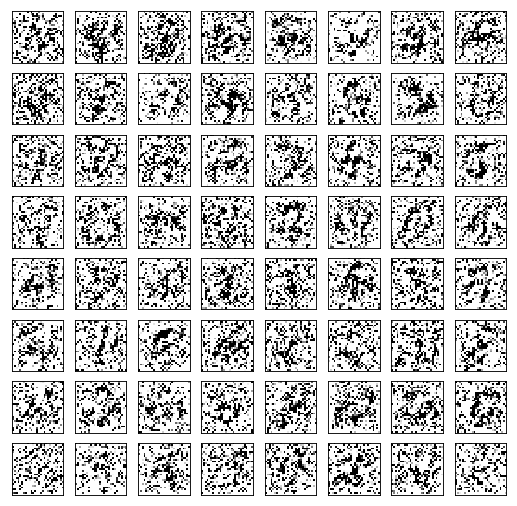

Iteration 1402000: loss=0.0008294772705994546
Iteration 1404000: loss=0.0008294768049381673
Iteration 1406000: loss=0.0008294761646538973
Iteration 1408000: loss=0.0008294752915389836
Iteration 1410000: loss=0.0008294749422930181
Iteration 1412000: loss=0.0008294744184240699
Iteration 1414000: loss=0.0008294739527627826
Iteration 1416000: loss=0.0008294735453091562
Iteration 1418000: loss=0.0008294733706861734
Iteration 1420000: loss=0.0008294733124785125
Iteration 1422000: loss=0.0008294729050248861
Iteration 1424000: loss=0.0008294726139865816
Iteration 1426000: loss=0.0008294719737023115
Iteration 1428000: loss=0.0008294719154946506
Iteration 1430000: loss=0.0008294708095490932
Iteration 1432000: loss=0.0008294706349261105
Iteration 1434000: loss=0.0008294701110571623
Iteration 1436000: loss=0.0008294694125652313
Iteration 1438000: loss=0.0008294695289805532
Iteration 1440000: loss=0.0008294692379422486


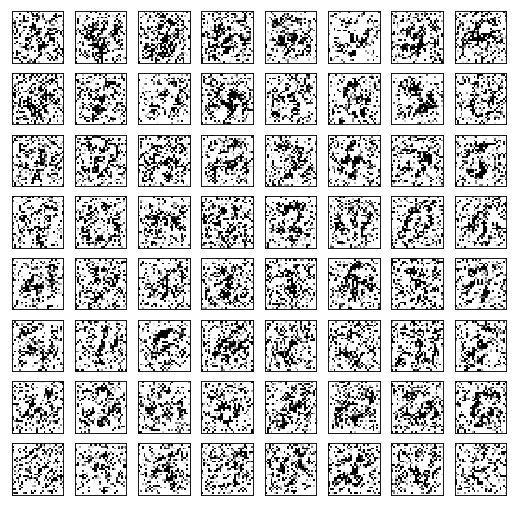

Iteration 1442000: loss=0.0008294691797345877
Iteration 1444000: loss=0.0008294683648273349
Iteration 1446000: loss=0.0008294678409583867
Iteration 1448000: loss=0.0008294674917124212
Iteration 1450000: loss=0.0008294667932204902
Iteration 1452000: loss=0.0008294662111438811
Iteration 1454000: loss=0.0008294661529362202
Iteration 1456000: loss=0.0008294651051983237
Iteration 1458000: loss=0.0008294647559523582
Iteration 1460000: loss=0.0008294641738757491
Iteration 1462000: loss=0.0008294637082144618
Iteration 1464000: loss=0.0008294632425531745
Iteration 1466000: loss=0.0008294625440612435
Iteration 1468000: loss=0.0008294617291539907
Iteration 1470000: loss=0.0008294612052850425
Iteration 1472000: loss=0.0008294604485854506
Iteration 1474000: loss=0.0008294600993394852
Iteration 1476000: loss=0.000829459575470537
Iteration 1478000: loss=0.0008294585859403014
Iteration 1480000: loss=0.0008294576546177268


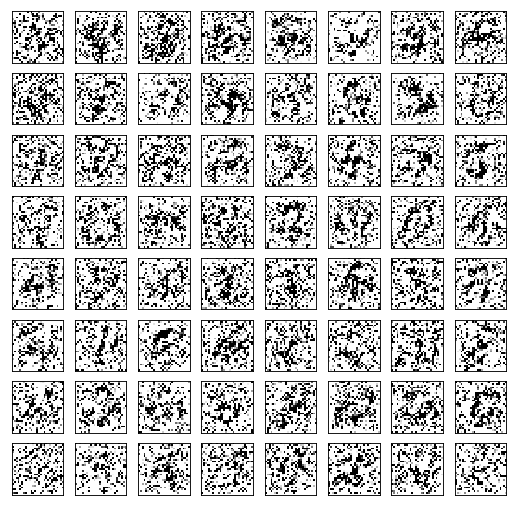

Iteration 1482000: loss=0.0008294569561257958
Iteration 1484000: loss=0.000829456141218543
Iteration 1486000: loss=0.0008294550352729857
Iteration 1488000: loss=0.0008294535800814629
Iteration 1490000: loss=0.00082945212488994
Iteration 1492000: loss=0.0008294502040371299
Iteration 1494000: loss=0.0008294479921460152
Iteration 1496000: loss=0.0008294449653476477
Iteration 1498000: loss=0.0008294394356198609
Iteration 1500000: loss=0.000829431926831603
Iteration 1502000: loss=0.0008294227882288396
Iteration 1504000: loss=0.0008294155122712255
Iteration 1506000: loss=0.0008294110302813351
Iteration 1508000: loss=0.000829408410936594
Iteration 1510000: loss=0.0008294064900837839
Iteration 1512000: loss=0.0008294048602692783
Iteration 1514000: loss=0.0008294038125313818
Iteration 1516000: loss=0.0008294029976241291
Iteration 1518000: loss=0.0008294022991321981
Iteration 1520000: loss=0.0008294014260172844


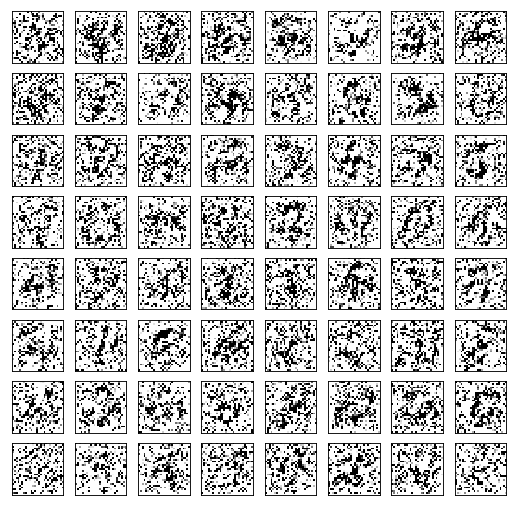

Iteration 1522000: loss=0.000829401018563658
Iteration 1524000: loss=0.0008294000290334225
Iteration 1526000: loss=0.0008293991559185088
Iteration 1528000: loss=0.0008293987484648824
Iteration 1530000: loss=0.0008293984574265778
Iteration 1532000: loss=0.0008293974096886814
Iteration 1534000: loss=0.0008293974678963423
Iteration 1536000: loss=0.000829397002235055
Iteration 1538000: loss=0.0008293961873278022
Iteration 1540000: loss=0.0008293958380818367
Iteration 1542000: loss=0.000829394964966923
Iteration 1544000: loss=0.0008293943828903139
Iteration 1546000: loss=0.0008293940918520093
Iteration 1548000: loss=0.0008293932187370956
Iteration 1550000: loss=0.0008293926366604865
Iteration 1552000: loss=0.0008293922292068601
Iteration 1554000: loss=0.0008293919963762164
Iteration 1556000: loss=0.0008293918217532337
Iteration 1558000: loss=0.0008293908904306591
Iteration 1560000: loss=0.0008293904247693717


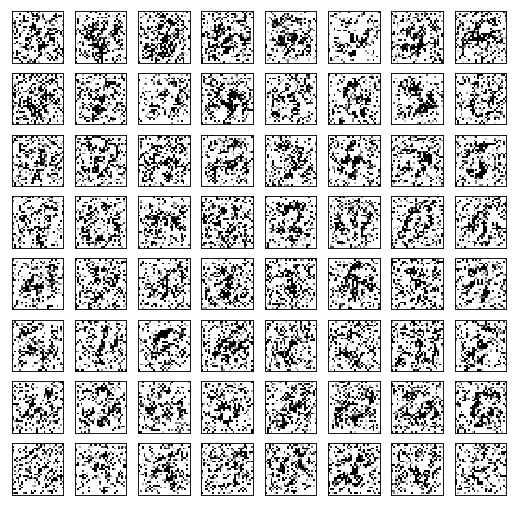

Iteration 1562000: loss=0.0008293900173157454
Iteration 1564000: loss=0.0008293893770314753
Iteration 1566000: loss=0.0008293888531625271
Iteration 1568000: loss=0.000829388212878257
Iteration 1570000: loss=0.0008293873979710042
Iteration 1572000: loss=0.0008293868158943951
Iteration 1574000: loss=0.0008293860009871423
Iteration 1576000: loss=0.0008293853607028723
Iteration 1578000: loss=0.0008293846040032804
Iteration 1580000: loss=0.0008293832070194185
Iteration 1582000: loss=0.0008293816354125738
Iteration 1584000: loss=0.0008293800638057292
Iteration 1586000: loss=0.0008293775608763099
Iteration 1588000: loss=0.0008293743012472987
Iteration 1590000: loss=0.0008293688297271729
Iteration 1592000: loss=0.0008293595747090876
Iteration 1594000: loss=0.0008293443243019283
Iteration 1596000: loss=0.0008293261053040624
Iteration 1598000: loss=0.0008293099817819893
Iteration 1600000: loss=0.0008292976999655366


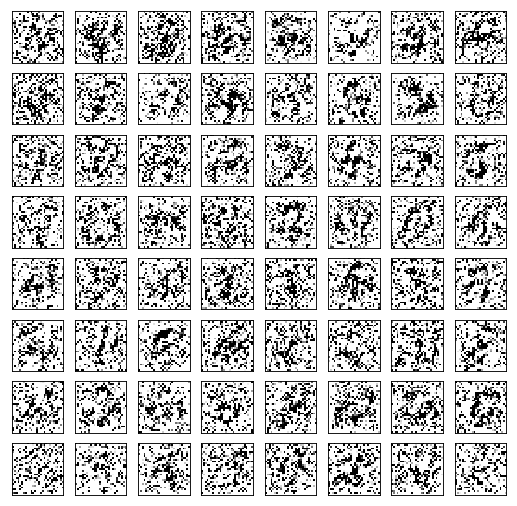

Iteration 1602000: loss=0.0008292875718325377
Iteration 1604000: loss=0.0008292784332297742
Iteration 1606000: loss=0.0008292703423649073
Iteration 1608000: loss=0.000829263124614954
Iteration 1610000: loss=0.0008292574784718454
Iteration 1612000: loss=0.0008292532293125987
Iteration 1614000: loss=0.0008292485726997256
Iteration 1616000: loss=0.0008292434504255652
Iteration 1618000: loss=0.0008292364072985947
Iteration 1620000: loss=0.0008292224956676364
Iteration 1622000: loss=0.0008291941485367715
Iteration 1624000: loss=0.0008291677222587168
Iteration 1626000: loss=0.0008291574195027351
Iteration 1628000: loss=0.0008291525882668793
Iteration 1630000: loss=0.0008291499689221382
Iteration 1632000: loss=0.0008291479316540062
Iteration 1634000: loss=0.0008291461854241788
Iteration 1636000: loss=0.0008291450212709606
Iteration 1638000: loss=0.0008291442063637078
Iteration 1640000: loss=0.0008291427511721849


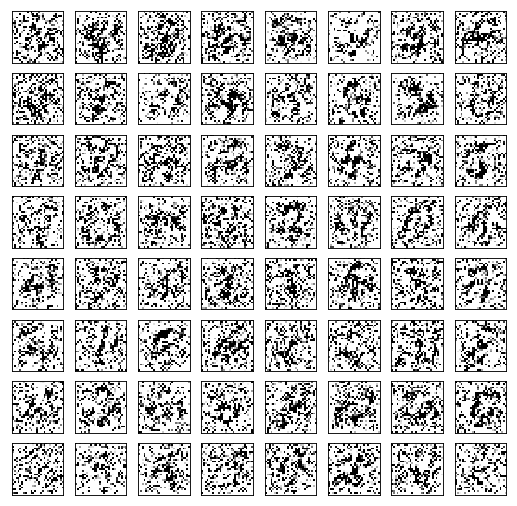

Iteration 1642000: loss=0.0008291412377730012
Iteration 1644000: loss=0.0008291403646580875
Iteration 1646000: loss=0.0008291395497508347
Iteration 1648000: loss=0.0008291387348435819
Iteration 1650000: loss=0.00082913797814399
Iteration 1652000: loss=0.0008291372214443982
Iteration 1654000: loss=0.0008291371050290763
Iteration 1656000: loss=0.0008291363483294845
Iteration 1658000: loss=0.0008291356498375535
Iteration 1660000: loss=0.0008291348931379616
Iteration 1662000: loss=0.0008291348349303007
Iteration 1664000: loss=0.0008291342528536916
Iteration 1666000: loss=0.0008291334379464388
Iteration 1668000: loss=0.0008291329722851515
Iteration 1670000: loss=0.0008291323902085423
Iteration 1672000: loss=0.0008291321573778987
Iteration 1674000: loss=0.0008291316335089505
Iteration 1676000: loss=0.0008291311096400023
Iteration 1678000: loss=0.0008291307603940368
Iteration 1680000: loss=0.0008291294216178358


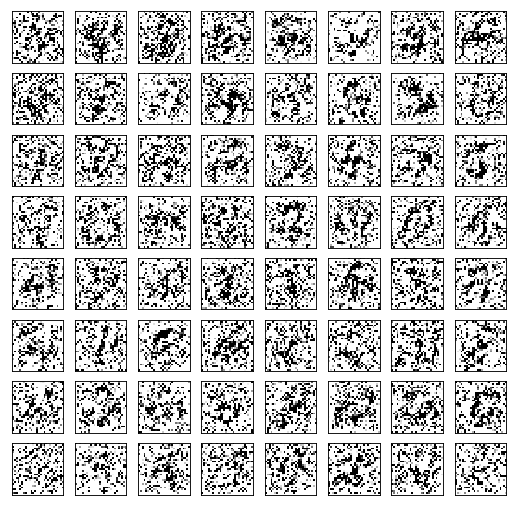

Iteration 1682000: loss=0.0008291288395412266
Iteration 1684000: loss=0.000829127908218652
Iteration 1686000: loss=0.000829127209726721
Iteration 1688000: loss=0.0008291269768960774
Iteration 1690000: loss=0.0008291263366118073
Iteration 1692000: loss=0.000829125929158181
Iteration 1694000: loss=0.00082912523066625
Iteration 1696000: loss=0.000829124532174319
Iteration 1698000: loss=0.0008291242411360145
Iteration 1700000: loss=0.0008291236590594053
Iteration 1702000: loss=0.0008291227859444916
Iteration 1704000: loss=0.0008291223202832043
Iteration 1706000: loss=0.0008291220874525607
Iteration 1708000: loss=0.0008291212725453079
Iteration 1710000: loss=0.0008291207486763597
Iteration 1712000: loss=0.0008291202830150723
Iteration 1714000: loss=0.000829119875561446
Iteration 1716000: loss=0.0008291201665997505
Iteration 1718000: loss=0.0008291197591461241
Iteration 1720000: loss=0.0008291194681078196


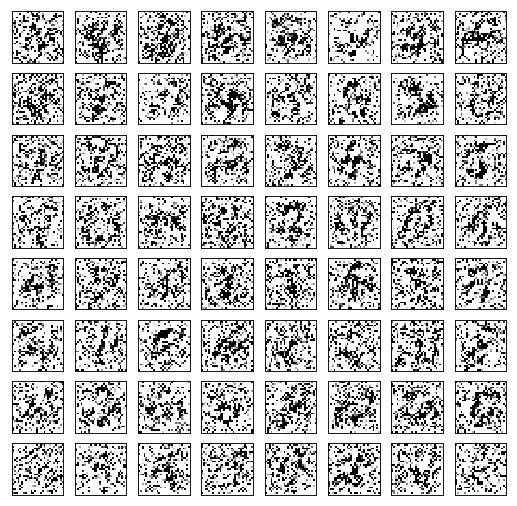

Iteration 1722000: loss=0.0008291186532005668
Iteration 1724000: loss=0.0008291185367852449
Iteration 1726000: loss=0.0008291182457469404
Iteration 1728000: loss=0.0008291179547086358
Iteration 1730000: loss=0.0008291174890473485
Iteration 1732000: loss=0.0008291170815937221
Iteration 1734000: loss=0.0008291164413094521
Iteration 1736000: loss=0.0008291157428175211
Iteration 1738000: loss=0.0008291155681945384
Iteration 1740000: loss=0.0008291148697026074
Iteration 1742000: loss=0.0008291144040413201
Iteration 1744000: loss=0.0008291146950796247
Iteration 1746000: loss=0.000829113821964711
Iteration 1748000: loss=0.0008291133563034236
Iteration 1750000: loss=0.0008291127160191536
Iteration 1752000: loss=0.0008291128324344754
Iteration 1754000: loss=0.000829112424980849
Iteration 1756000: loss=0.0008291116100735962
Iteration 1758000: loss=0.0008291114936582744
Iteration 1760000: loss=0.0008291109115816653


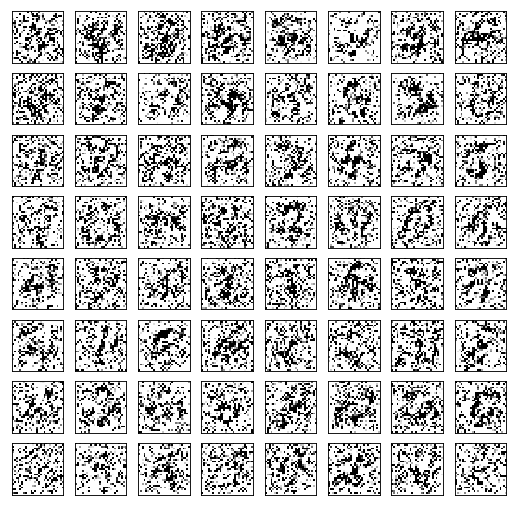

Iteration 1762000: loss=0.000829110445920378
Iteration 1764000: loss=0.0008291098638437688
Iteration 1766000: loss=0.0008291096310131252
Iteration 1768000: loss=0.0008291091653518379
Iteration 1770000: loss=0.0008291089907288551
Iteration 1772000: loss=0.0008291080594062805
Iteration 1774000: loss=0.0008291075355373323
Iteration 1776000: loss=0.0008291067788377404
Iteration 1778000: loss=0.0008291059639304876
Iteration 1780000: loss=0.0008291050908155739
Iteration 1782000: loss=0.0008291035192087293
Iteration 1784000: loss=0.0008291018311865628
Iteration 1786000: loss=0.0008290999685414135
Iteration 1788000: loss=0.0008290975820273161
Iteration 1790000: loss=0.0008290943223983049
Iteration 1792000: loss=0.0008290907717309892
Iteration 1794000: loss=0.0008290877449326217
Iteration 1796000: loss=0.0008290845435112715
Iteration 1798000: loss=0.000829081516712904
Iteration 1800000: loss=0.0008290793048217893


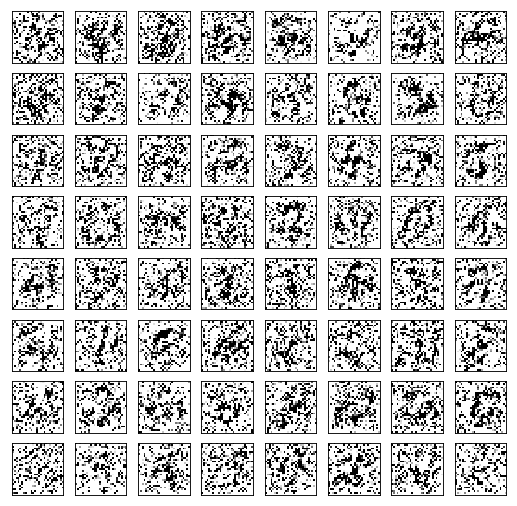

Iteration 1802000: loss=0.0008290772675536573
Iteration 1804000: loss=0.0008290760451927781
Iteration 1806000: loss=0.000829074764624238
Iteration 1808000: loss=0.0008290740079246461
Iteration 1810000: loss=0.0008290729019790888
Iteration 1812000: loss=0.0008290720288641751
Iteration 1814000: loss=0.0008290708065032959
Iteration 1816000: loss=0.0008290710393339396
Iteration 1818000: loss=0.0008290701662190259
Iteration 1820000: loss=0.0008290692348964512
Iteration 1822000: loss=0.000829068070743233
Iteration 1824000: loss=0.0008290671976283193
Iteration 1826000: loss=0.0008290662663057446
Iteration 1828000: loss=0.0008290645782835782
Iteration 1830000: loss=0.0008290637633763254
Iteration 1832000: loss=0.0008290623663924634
Iteration 1834000: loss=0.0008290612604469061
Iteration 1836000: loss=0.0008290599216707051
Iteration 1838000: loss=0.0008290589321404696
Iteration 1840000: loss=0.0008290577679872513


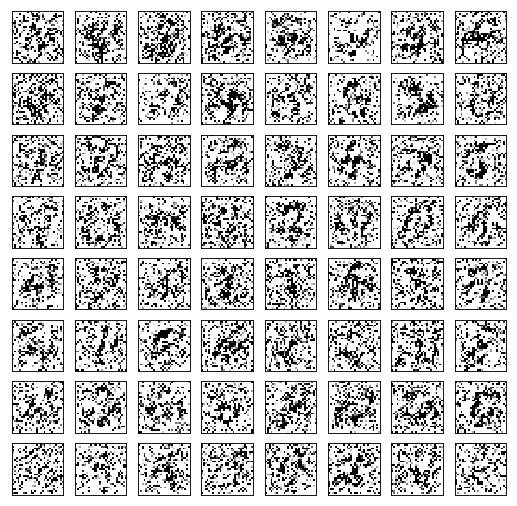

Iteration 1842000: loss=0.0008290561963804066
Iteration 1844000: loss=0.0008290550322271883
Iteration 1846000: loss=0.0008290547993965447
Iteration 1848000: loss=0.0008290540426969528
Iteration 1850000: loss=0.0008290527039207518
Iteration 1852000: loss=0.0008290526457130909
Iteration 1854000: loss=0.0008290518308058381
Iteration 1856000: loss=0.0008290513069368899
Iteration 1858000: loss=0.0008290508994832635
Iteration 1860000: loss=0.0008290507830679417
Iteration 1862000: loss=0.0008290504338219762
Iteration 1864000: loss=0.000829049909953028
Iteration 1866000: loss=0.0008290493278764188
Iteration 1868000: loss=0.0008290495607070625
Iteration 1870000: loss=0.0008290488622151315
Iteration 1872000: loss=0.0008290486293844879
Iteration 1874000: loss=0.0008290481637232006
Iteration 1876000: loss=0.0008290477562695742
Iteration 1878000: loss=0.0008290476980619133
Iteration 1880000: loss=0.0008290474070236087


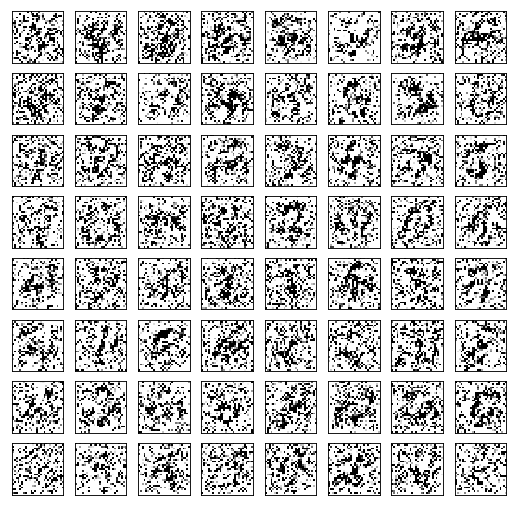

Iteration 1882000: loss=0.0008290468249469995
Iteration 1884000: loss=0.0008290463592857122
Iteration 1886000: loss=0.0008290462428703904
Iteration 1888000: loss=0.0008290454861707985
Iteration 1890000: loss=0.0008290450205095112
Iteration 1892000: loss=0.0008290447294712067
Iteration 1894000: loss=0.0008290443802252412
Iteration 1896000: loss=0.0008290440309792757
Iteration 1898000: loss=0.0008290435071103275
Iteration 1900000: loss=0.0008290432742796838
Iteration 1902000: loss=0.0008290429250337183
Iteration 1904000: loss=0.0008290426922030747
Iteration 1906000: loss=0.0008290422847494483
Iteration 1908000: loss=0.0008290418772958219
Iteration 1910000: loss=0.0008290413534268737
Iteration 1912000: loss=0.0008290412370115519
Iteration 1914000: loss=0.0008290406549349427
Iteration 1916000: loss=0.0008290405385196209
Iteration 1918000: loss=0.0008290402474813163
Iteration 1920000: loss=0.000829039781820029


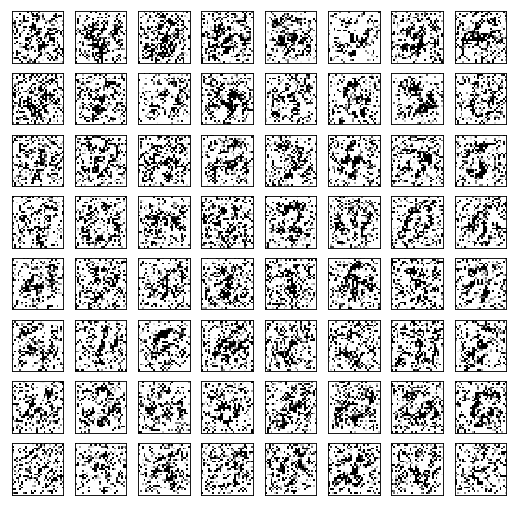

Iteration 1922000: loss=0.0008290394325740635
Iteration 1924000: loss=0.0008290390833280981
Iteration 1926000: loss=0.0008290387922897935
Iteration 1928000: loss=0.0008290385012514889
Iteration 1930000: loss=0.0008290382684208453
Iteration 1932000: loss=0.0008290378609672189
Iteration 1934000: loss=0.0008290376863442361
Iteration 1936000: loss=0.0008290373370982707
Iteration 1938000: loss=0.0008290375117212534
Iteration 1940000: loss=0.0008290372788906097
Iteration 1942000: loss=0.0008290373370982707
Iteration 1944000: loss=0.0008290372788906097
Iteration 1946000: loss=0.0008290366386063397
Iteration 1948000: loss=0.0008290369878523052
Iteration 1950000: loss=0.0008290368132293224
Iteration 1952000: loss=0.0008290367550216615
Iteration 1954000: loss=0.0008290369878523052
Loss is rising .. stop


In [10]:
new_image_batch = generate_image(img)

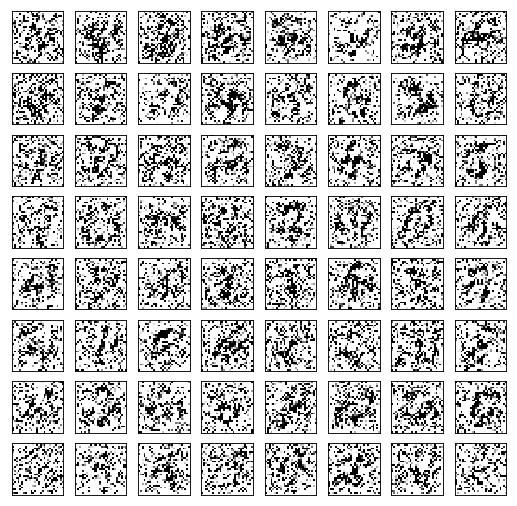

In [11]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [12]:
latent = model.E(new_image_batch.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 0.8630,  0.0034,  0.0131,  ...,  0.0025,  0.0252,  0.0191],
        [ 0.0053,  0.9322,  0.0208,  ...,  0.0031,  0.0034,  0.0007],
        [ 0.0023,  0.0406,  0.8975,  ...,  0.0022,  0.0013,  0.0008],
        ...,
        [ 0.0039,  0.0094,  0.0067,  ...,  0.8556,  0.0163,  0.0019],
        [ 0.0182,  0.0065,  0.0042,  ...,  0.0242,  0.8591,  0.0021],
        [ 0.0428,  0.0054,  0.0050,  ...,  0.0065,  0.0040,  0.8595]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


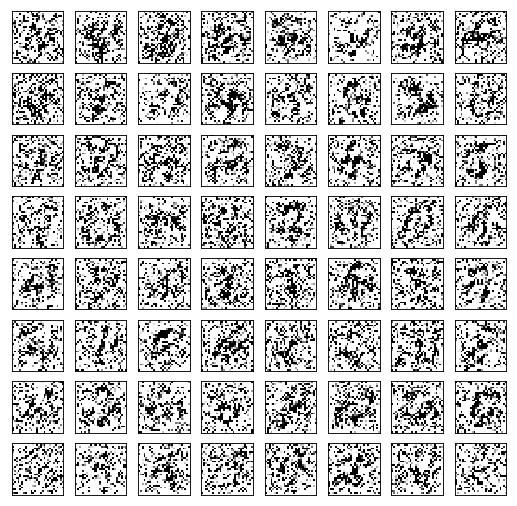

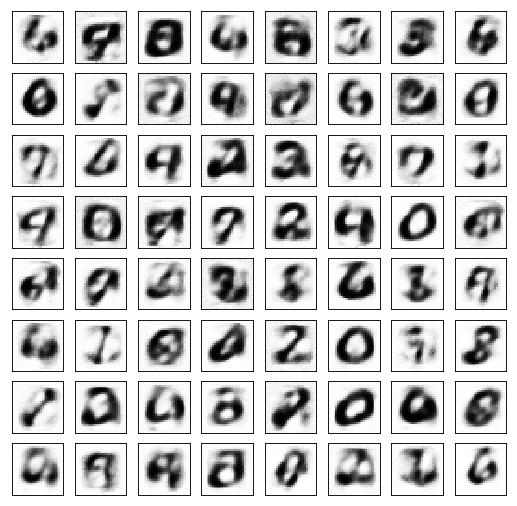

In [13]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_batch.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))    

### Генерация изображений из случайного шума

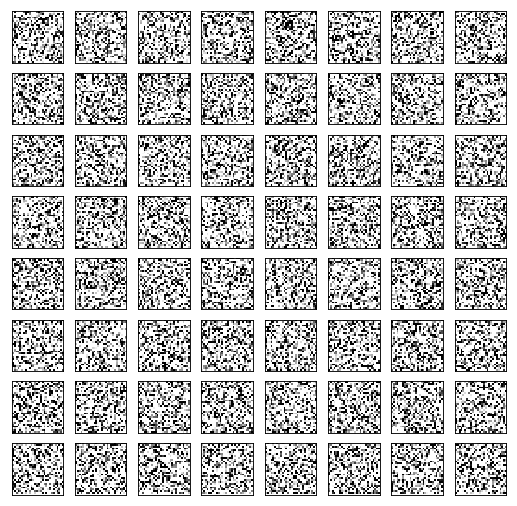

In [17]:
img = torch.randn(64, 784) 
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.005011526867747307
Iteration 4000: loss=0.002365252235904336
Iteration 6000: loss=0.001542756101116538
Iteration 8000: loss=0.0011745489900931716
Iteration 10000: loss=0.0009971392573788762
Iteration 12000: loss=0.000912874354980886
Iteration 14000: loss=0.0008705048821866512
Iteration 16000: loss=0.000849036208819598
Iteration 18000: loss=0.0008373779710382223
Iteration 20000: loss=0.0008314628503285348
Iteration 22000: loss=0.0008281042682938278
Iteration 24000: loss=0.0008267017547041178
Iteration 26000: loss=0.0008254816639237106
Iteration 28000: loss=0.000824270595330745
Iteration 30000: loss=0.000823770766146481
Iteration 32000: loss=0.0008219942101277411
Iteration 34000: loss=0.0008202344179153442
Iteration 36000: loss=0.0008194888941943645
Iteration 38000: loss=0.0008191574015654624
Iteration 40000: loss=0.0008189185755327344


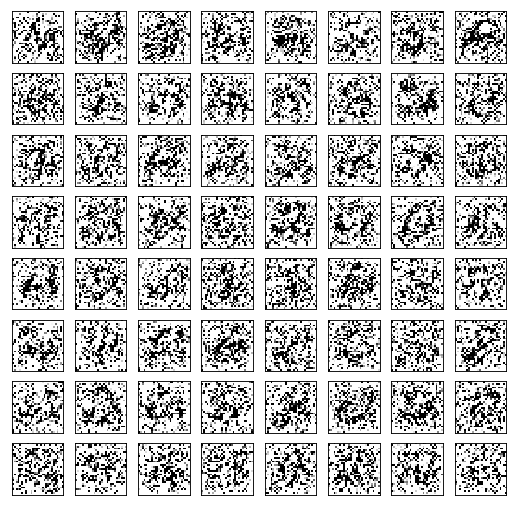

Iteration 42000: loss=0.0008187823696061969
Iteration 44000: loss=0.0008186756167560816
Iteration 46000: loss=0.0008180670556612313
Iteration 48000: loss=0.0008179611177183688
Iteration 50000: loss=0.000817873515188694
Iteration 52000: loss=0.0008176990086212754
Iteration 54000: loss=0.0008174392278306186
Iteration 56000: loss=0.0008173479000106454
Iteration 58000: loss=0.0008172864909283817
Iteration 60000: loss=0.0008167288033291698
Iteration 62000: loss=0.0008166790357790887
Iteration 64000: loss=0.0008166377083398402
Iteration 66000: loss=0.0008166030747815967
Iteration 68000: loss=0.0008165606413967907
Iteration 70000: loss=0.000816169660538435
Iteration 72000: loss=0.000816104409750551
Iteration 74000: loss=0.0008160737925209105
Iteration 76000: loss=0.0008160479483194649
Iteration 78000: loss=0.0008160213474184275
Iteration 80000: loss=0.0008159783319570124


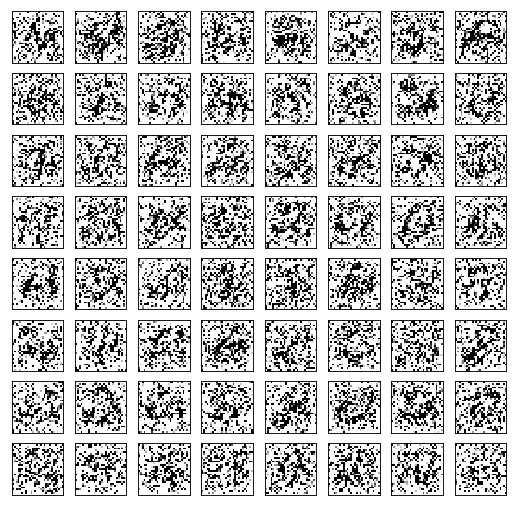

Iteration 82000: loss=0.0008158694254234433
Iteration 84000: loss=0.0008158249547705054
Iteration 86000: loss=0.0008157964912243187
Iteration 88000: loss=0.0008157729753293097
Iteration 90000: loss=0.0008157463744282722
Iteration 92000: loss=0.0008155907853506505
Iteration 94000: loss=0.0008155609830282629
Iteration 96000: loss=0.0008155214018188417
Iteration 98000: loss=0.0008155022514984012
Iteration 100000: loss=0.0008154556853696704
Iteration 102000: loss=0.0008154211682267487
Iteration 104000: loss=0.0008153714006766677
Iteration 106000: loss=0.000815270293969661
Iteration 108000: loss=0.0008152520749717951
Iteration 110000: loss=0.0008152416558004916
Iteration 112000: loss=0.0008152316440828145
Iteration 114000: loss=0.0008152229129336774
Iteration 116000: loss=0.000815215811599046
Iteration 118000: loss=0.0008152071386575699
Iteration 120000: loss=0.0008151990477927029


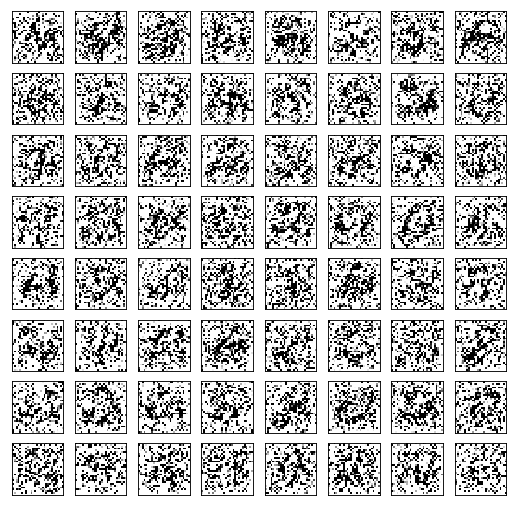

Iteration 122000: loss=0.0008151924703270197
Iteration 124000: loss=0.0008151846705004573
Iteration 126000: loss=0.0008151712827384472
Iteration 128000: loss=0.0008150874637067318
Iteration 130000: loss=0.0008150747162289917
Iteration 132000: loss=0.0008148891502059996
Iteration 134000: loss=0.0008148397319018841
Iteration 136000: loss=0.0008148290798999369
Iteration 138000: loss=0.0008148206397891045
Iteration 140000: loss=0.0008148130145855248
Iteration 142000: loss=0.0008147968328557909
Iteration 144000: loss=0.0008144444436766207
Iteration 146000: loss=0.0008144279127009213
Iteration 148000: loss=0.0008143847226165235
Iteration 150000: loss=0.000814375642221421
Iteration 152000: loss=0.0008143692393787205
Iteration 154000: loss=0.0008143638260662556
Iteration 156000: loss=0.0008143580635078251
Iteration 158000: loss=0.0008143518352881074
Iteration 160000: loss=0.0008143463637679815


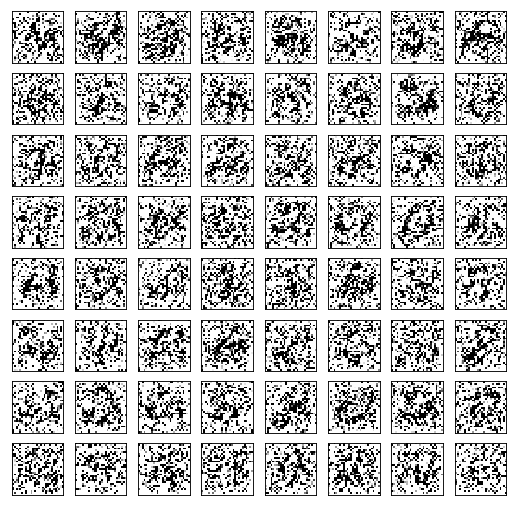

Iteration 162000: loss=0.0008143423474393785
Iteration 164000: loss=0.0008143379236571491
Iteration 166000: loss=0.0008143330924212933
Iteration 168000: loss=0.0008143297163769603
Iteration 170000: loss=0.00081432587467134
Iteration 172000: loss=0.0008143225568346679
Iteration 174000: loss=0.0008143206359818578
Iteration 176000: loss=0.0008143179002217948
Iteration 178000: loss=0.000814314465969801
Iteration 180000: loss=0.0008143119630403817
Iteration 182000: loss=0.0008143086452037096
Iteration 184000: loss=0.0008143061422742903
Iteration 186000: loss=0.0008143027662299573
Iteration 188000: loss=0.0008143006125465035
Iteration 190000: loss=0.0008142978185787797
Iteration 192000: loss=0.0008142946171574295
Iteration 194000: loss=0.0008142921142280102
Iteration 196000: loss=0.0008142885053530335
Iteration 198000: loss=0.0008142846054397523
Iteration 200000: loss=0.0008142663864418864


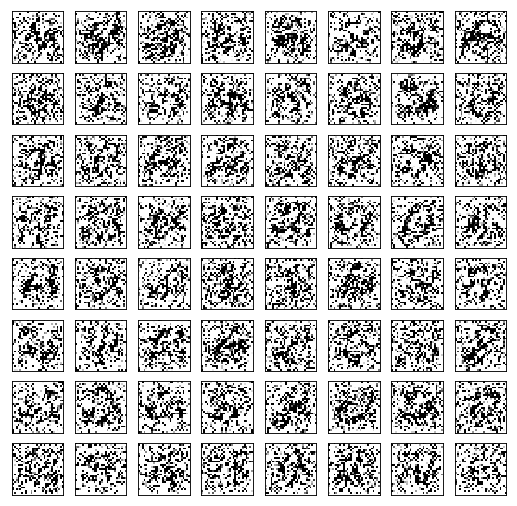

Iteration 202000: loss=0.0008142571896314621
Iteration 204000: loss=0.000814254570286721
Iteration 206000: loss=0.0008142513106577098
Iteration 208000: loss=0.000814249215181917
Iteration 210000: loss=0.0008142472361214459
Iteration 212000: loss=0.0008142453734762967
Iteration 214000: loss=0.0008142428705468774
Iteration 216000: loss=0.0008142403094097972
Iteration 218000: loss=0.0008142382721416652
Iteration 220000: loss=0.0008142351871356368
Iteration 222000: loss=0.0008142301812767982
Iteration 224000: loss=0.0008142272708937526
Iteration 226000: loss=0.0008142251172102988
Iteration 228000: loss=0.0008142228471115232
Iteration 230000: loss=0.0008142185979522765
Iteration 232000: loss=0.0008142148144543171
Iteration 234000: loss=0.0008142130682244897
Iteration 236000: loss=0.0008142115548253059
Iteration 238000: loss=0.0008142100996337831
Iteration 240000: loss=0.0008142090518958867


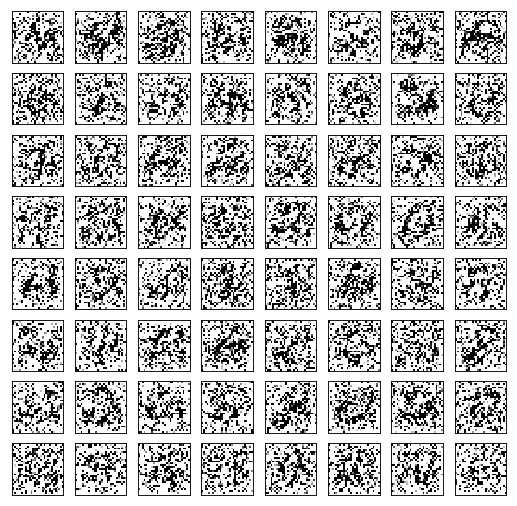

Iteration 242000: loss=0.0008142069564200938
Iteration 244000: loss=0.0008142058504745364
Iteration 246000: loss=0.0008142046863213181
Iteration 248000: loss=0.0008142030565068126
Iteration 250000: loss=0.0008142018341459334
Iteration 252000: loss=0.000814200786408037
Iteration 254000: loss=0.0008141989819705486
Iteration 256000: loss=0.0008141975267790258
Iteration 258000: loss=0.0008141955477185547
Iteration 260000: loss=0.0008141937432810664
Iteration 262000: loss=0.0008141922298818827
Iteration 264000: loss=0.0008141907746903598
Iteration 266000: loss=0.000814189319498837
Iteration 268000: loss=0.0008141882135532796
Iteration 270000: loss=0.0008141864091157913
Iteration 272000: loss=0.0008141858270391822
Iteration 274000: loss=0.0008141851867549121
Iteration 276000: loss=0.0008141844300553203
Iteration 278000: loss=0.0008141831494867802
Iteration 280000: loss=0.0008141824509948492


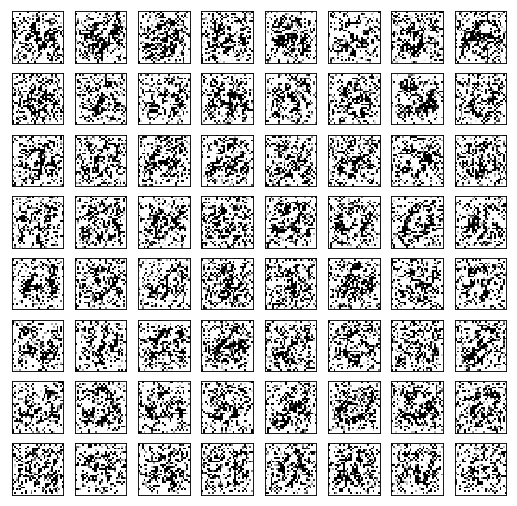

Iteration 282000: loss=0.0008141816360875964
Iteration 284000: loss=0.0008141806465573609
Iteration 286000: loss=0.0008141797734424472
Iteration 288000: loss=0.0008141783764585853
Iteration 290000: loss=0.0008141773869283497
Iteration 292000: loss=0.0008141768048517406
Iteration 294000: loss=0.0008141754660755396
Iteration 296000: loss=0.0008141744183376431
Iteration 298000: loss=0.0008141733705997467
Iteration 300000: loss=0.0008141723810695112
Iteration 302000: loss=0.000814171798992902
Iteration 304000: loss=0.0008141709258779883
Iteration 306000: loss=0.0008141708094626665
Iteration 308000: loss=0.0008141696453094482
Iteration 310000: loss=0.0008141688886098564
Iteration 312000: loss=0.0008141685393638909
Iteration 314000: loss=0.0008141672587953508
Iteration 316000: loss=0.0008141666185110807
Iteration 318000: loss=0.0008141655125655234
Iteration 320000: loss=0.0008141645812429488


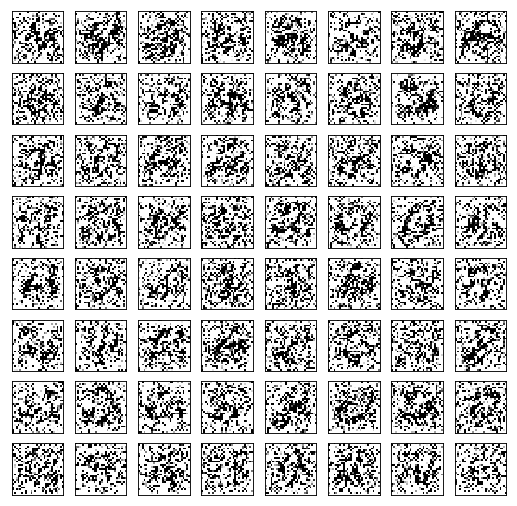

Iteration 322000: loss=0.0008141638827510178
Iteration 324000: loss=0.0008141629514284432
Iteration 326000: loss=0.0008141622529365122
Iteration 328000: loss=0.0008141607395373285
Iteration 330000: loss=0.0008141602156683803
Iteration 332000: loss=0.0008141599246300757
Iteration 334000: loss=0.0008141595753841102
Iteration 336000: loss=0.0008141587022691965
Iteration 338000: loss=0.0008141579455696046
Iteration 340000: loss=0.0008141568978317082
Iteration 342000: loss=0.0008141560829244554
Iteration 344000: loss=0.0008141555590555072
Iteration 346000: loss=0.0008141548605635762
Iteration 348000: loss=0.0008141543949022889
Iteration 350000: loss=0.0008141537546180189
Iteration 352000: loss=0.0008141531725414097
Iteration 354000: loss=0.0008141523576341569
Iteration 356000: loss=0.0008141520665958524
Iteration 358000: loss=0.0008141510770656168
Iteration 360000: loss=0.0008141509024426341


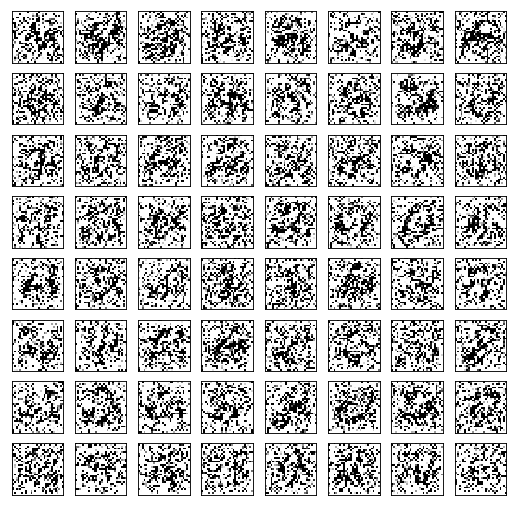

Iteration 362000: loss=0.0008141503785736859
Iteration 364000: loss=0.0008141498547047377
Iteration 366000: loss=0.0008141490980051458
Iteration 368000: loss=0.000814148981589824
Iteration 370000: loss=0.0008141483995132148
Iteration 372000: loss=0.000814147584605962
Iteration 374000: loss=0.000814146944321692
Iteration 376000: loss=0.0008141465368680656
Iteration 378000: loss=0.0008141452562995255
Iteration 380000: loss=0.0008141442085616291
Iteration 382000: loss=0.0008141421130858362
Iteration 384000: loss=0.0008141291909851134
Iteration 386000: loss=0.0008141135331243277
Iteration 388000: loss=0.0008140202844515443
Iteration 390000: loss=0.0008140064310282469
Iteration 392000: loss=0.0008140032878145576
Iteration 394000: loss=0.000814001658000052
Iteration 396000: loss=0.0008140006102621555
Iteration 398000: loss=0.0008139995043165982
Iteration 400000: loss=0.0008139981655403972


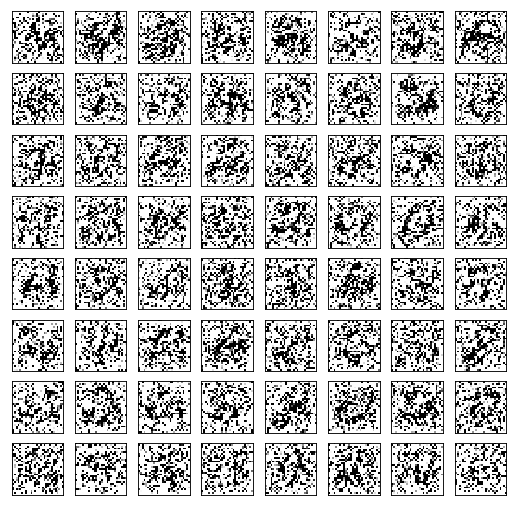

Iteration 402000: loss=0.0008139953715726733
Iteration 404000: loss=0.0008139933925122023
Iteration 406000: loss=0.0008139926940202713
Iteration 408000: loss=0.000813992228358984
Iteration 410000: loss=0.0008139919373206794
Iteration 412000: loss=0.0008139907731674612
Iteration 414000: loss=0.0008139902492985129
Iteration 416000: loss=0.0008139899582602084
Iteration 418000: loss=0.0008139893179759383
Iteration 420000: loss=0.0008139889687299728
Iteration 422000: loss=0.0008139883284457028
Iteration 424000: loss=0.000813988212030381
Iteration 426000: loss=0.0008139878045767546
Iteration 428000: loss=0.0008139876881614327
Iteration 430000: loss=0.0008139866404235363
Iteration 432000: loss=0.0008139863493852317
Iteration 434000: loss=0.0008139860001392663
Iteration 436000: loss=0.0008139859419316053
Iteration 438000: loss=0.0008139854180626571
Iteration 440000: loss=0.0008139846613630652


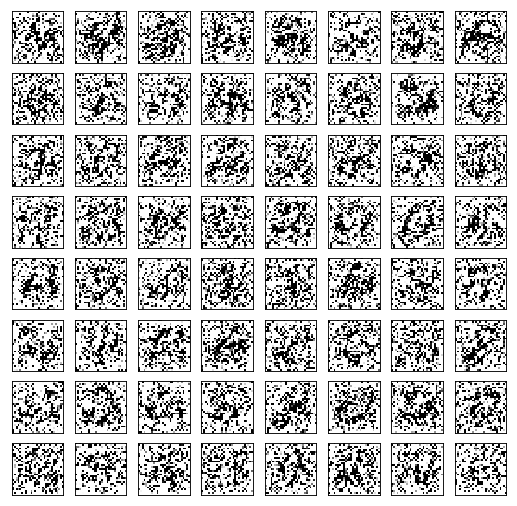

Iteration 442000: loss=0.0008139844285324216
Iteration 444000: loss=0.0008139839046634734
Iteration 446000: loss=0.0008139833807945251
Iteration 448000: loss=0.0008139829733408988
Iteration 450000: loss=0.0008139824494719505
Iteration 452000: loss=0.0008139819838106632
Iteration 454000: loss=0.0008139819838106632
Iteration 456000: loss=0.0008139815181493759
Iteration 458000: loss=0.0008139812271110713
Iteration 460000: loss=0.0008139806450344622
Iteration 462000: loss=0.000813980121165514
Iteration 464000: loss=0.0008139793062582612
Iteration 466000: loss=0.0008139789570122957
Iteration 468000: loss=0.0008139785495586693
Iteration 470000: loss=0.0008139780256897211
Iteration 472000: loss=0.0008139773271977901
Iteration 474000: loss=0.0008139771525748074
Iteration 476000: loss=0.0008139766287058592
Iteration 478000: loss=0.00081397604662925
Iteration 480000: loss=0.0008139759302139282


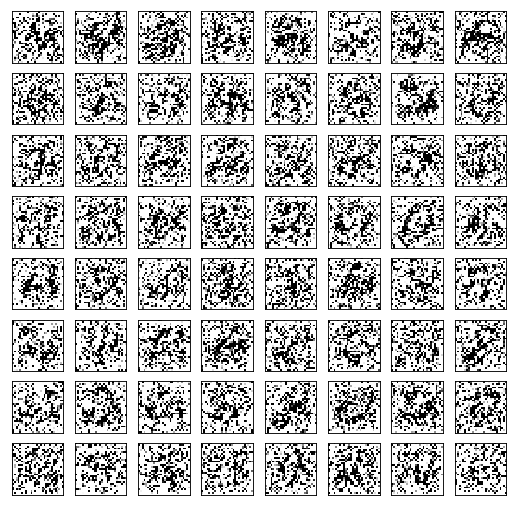

Iteration 482000: loss=0.0008139755809679627
Iteration 484000: loss=0.0008139752317219973
Iteration 486000: loss=0.0008139755227603018
Iteration 488000: loss=0.0008139746496453881
Iteration 490000: loss=0.0008139745914377272
Iteration 492000: loss=0.0008139738929457963
Iteration 494000: loss=0.0008139729616232216
Iteration 496000: loss=0.000813972728792578
Iteration 498000: loss=0.0008139722631312907
Iteration 500000: loss=0.0008139720885083079
Iteration 502000: loss=0.0008139719720929861
Iteration 504000: loss=0.0008139715064316988
Iteration 506000: loss=0.0008139712153933942
Iteration 508000: loss=0.0008139711571857333
Iteration 510000: loss=0.0008139709825627506
Iteration 512000: loss=0.0008139701676554978
Iteration 514000: loss=0.000813970051240176
Iteration 516000: loss=0.0008139695273712277
Iteration 518000: loss=0.000813969352748245
Iteration 520000: loss=0.000813968712463975


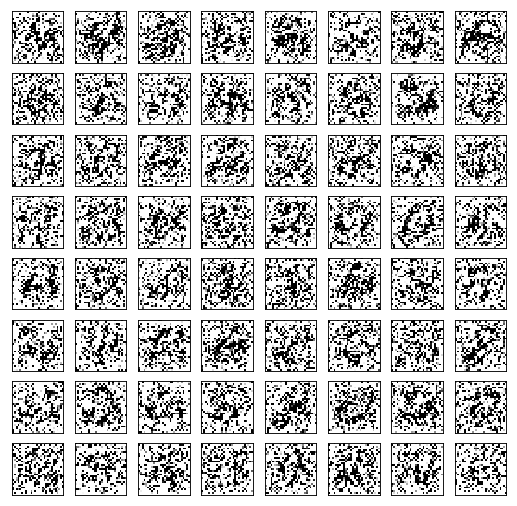

Iteration 522000: loss=0.0008139690617099404
Iteration 524000: loss=0.0008139683632180095
Iteration 526000: loss=0.0008139682468026876
Iteration 528000: loss=0.000813968013972044
Iteration 530000: loss=0.0008139675483107567
Iteration 532000: loss=0.0008139672572724521
Iteration 534000: loss=0.0008139667916111648
Iteration 536000: loss=0.0008139666169881821
Iteration 538000: loss=0.0008139665005728602
Iteration 540000: loss=0.0008139665005728602
Iteration 542000: loss=0.0008139660931192338
Iteration 544000: loss=0.0008139658020809293
Iteration 546000: loss=0.000813965336419642
Iteration 548000: loss=0.0008139649871736765
Iteration 550000: loss=0.0008139648707583547
Iteration 552000: loss=0.0008139646961353719
Iteration 554000: loss=0.0008139644050970674
Iteration 556000: loss=0.0008139638812281191
Iteration 558000: loss=0.0008139638230204582
Iteration 560000: loss=0.0008139637066051364


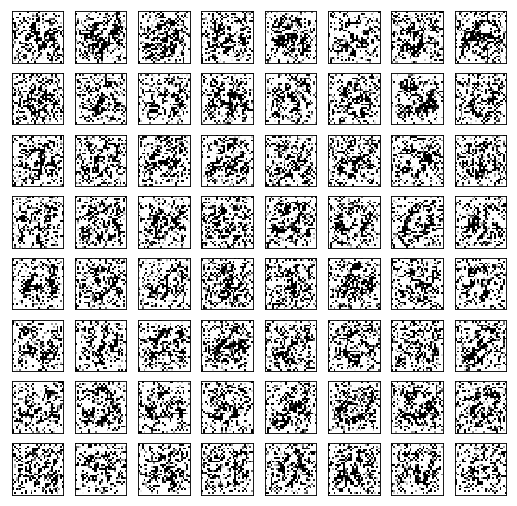

Iteration 562000: loss=0.0008139628916978836
Iteration 564000: loss=0.0008139625424519181
Iteration 566000: loss=0.0008139624260365963
Iteration 568000: loss=0.0008139618439599872
Iteration 570000: loss=0.0008139615529216826
Iteration 572000: loss=0.0008139614365063608
Iteration 574000: loss=0.0008139605051837862
Iteration 576000: loss=0.0008139598066918552
Iteration 578000: loss=0.0008139591664075851
Iteration 580000: loss=0.0008139571291394532
Iteration 582000: loss=0.0008139547426253557
Iteration 584000: loss=0.0008139538113027811
Iteration 586000: loss=0.0008139535202644765
Iteration 588000: loss=0.0008139530546031892
Iteration 590000: loss=0.0008139528217725456
Iteration 592000: loss=0.0008139526471495628
Iteration 594000: loss=0.0008139520650729537
Iteration 596000: loss=0.0008139520650729537
Iteration 598000: loss=0.0008139520068652928
Iteration 600000: loss=0.0008139514829963446


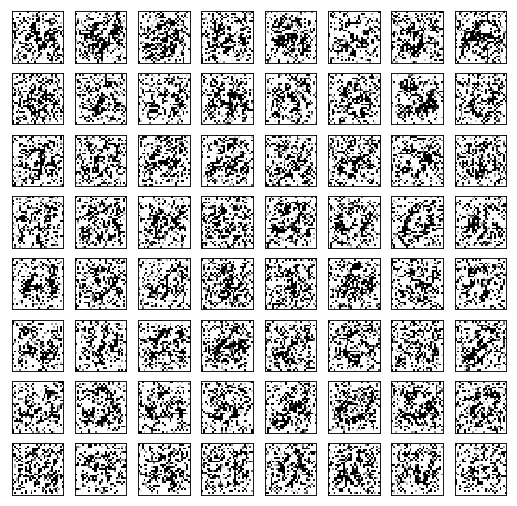

Iteration 602000: loss=0.0008139515412040055
Iteration 604000: loss=0.0008139511337503791
Iteration 606000: loss=0.0008139509591273963
Iteration 608000: loss=0.0008139506098814309
Iteration 610000: loss=0.0008139502024278045
Iteration 612000: loss=0.0008139501442201436
Iteration 614000: loss=0.000813949853181839
Iteration 616000: loss=0.000813949853181839
Iteration 618000: loss=0.0008139499113894999
Loss is rising .. stop


In [18]:
new_image_randn = generate_image(img)

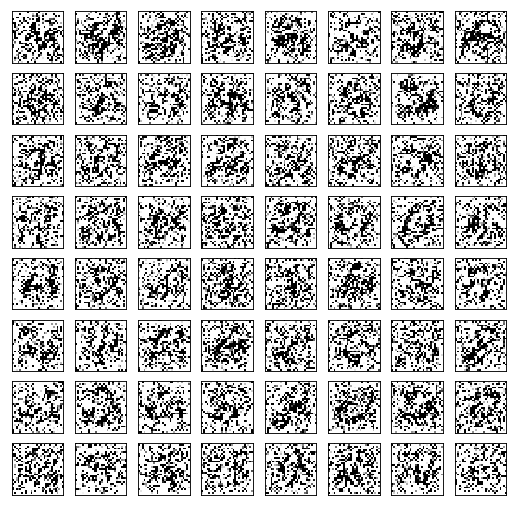

In [19]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [20]:
latent = model.E(new_image_randn.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 0.8536,  0.0079,  0.0091,  ...,  0.0016,  0.0278,  0.0178],
        [ 0.0073,  0.9349,  0.0210,  ...,  0.0044,  0.0038,  0.0006],
        [ 0.0023,  0.0406,  0.8975,  ...,  0.0022,  0.0013,  0.0008],
        ...,
        [ 0.0040,  0.0125,  0.0075,  ...,  0.8629,  0.0152,  0.0017],
        [ 0.0183,  0.0065,  0.0042,  ...,  0.0242,  0.8591,  0.0021],
        [ 0.0428,  0.0054,  0.0050,  ...,  0.0065,  0.0040,  0.8595]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


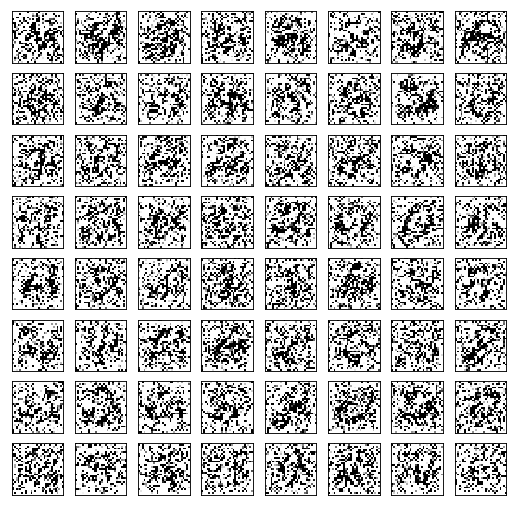

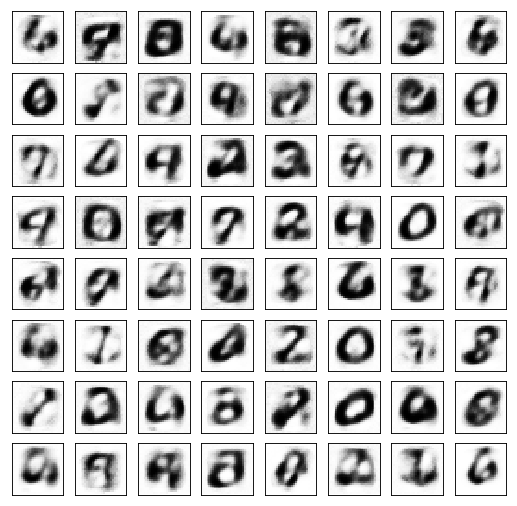

In [21]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_randn.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8)) 